# <h1 align=center> **PROYECTO INDIVIDUAL Nº2** </h1>
# <h1 align=center>**`Cryptocurrency Market Data Analytics`**</h1>

Este notebook es desarrollado por un Analista de Datos que trabaja para una empresa de servicios financieros interesada en el mercado de criptomonedas debido a su crecimiento exponencial y el potencial de oportunidades de inversión para los clientes. Así que, en el presente se realiza un análisis exhaustivo (EDA - Exploratory Data Analysis) de 10 criptomonedas, utilizando datos de la API CoinGecko, y presenta las respectivas conclusiones de cada una de ellas.

Es importante aclarar que para el análisis se usó como datos o variables criptográficas: precio de la moneda, capitalización de mercado y volumen total de transacciones. Esto en un rango de fechas que va desde el 01/01/2020 hasta 18/08/2023.

## **EDA - Exploratory Data Analysis**

Importación de las librerías

In [78]:
from pycoingecko import CoinGeckoAPI
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

Instanciación de la librería de Coingecko 

In [79]:
cg = CoinGeckoAPI()

Se eligen 10 criptomonedas situadas en el top 15 de precios, según la capitalización de mercado, mostradas en la página de Coingecko el día 18 de agosto del año 2023. Estas son: 'Bitcoin', 'Ethereum', 'Binancecoin (BNB)', 'Ripple (XRP)', 'Cardano', 'Dogecoin', 'Solana', 'Polkadot', 'Matic-Network (Polygon)' y 'Litecoin'. Todas ellas son conocidas y bien ponderadas por varios expertos en criptomonedas, quienes además concuerdan en que algunas de estas poseen un potencial real de generar rendimientos en el segundo semestre del presente año.

Aquí están algunos enlaces de donde se extrajo la información:

https://www.businessinsider.es/cripto/criptomonedas-con-mas-potencial

https://www.plus500.com/es/Trading/CryptoCurrencies/What-are-the-Most-Traded-Cryptocurrencies~2#:~:text=Adem%C3%A1s%20de%20Bitcoin%20y%20Ethereum,y%20popularidad%20tienden%20a%20fluctuar

<img src="imagenes\crypto_top_15.png">

El servicio o endpoint de la API que se eligió fue: `'/coins/{id}/market_chart/range'`, el cual permite obtener datos de mercado históricos como el precio (prices), la capitalización de mercado (market caps) y el volumen cada 24 horas (total volumes) dentro de un rango de tiempo especificado. En este endpoint los parámetros obligatorios son: 'id' o identificador de la moneda, 'vs_currency' que es la moneda en la que se desea ver los datos de mercado de la cripto, 'from_timestamp' y 'to_timestamp' que representan el rango de fechas (inicio y final, respectivamente) en el cual se desea obtener los datos (deben estar en formato UNIX); y como parámetro opcional está 'precision' que indica el número de decimales que se desea tener en los datos.

Un ejemplo del funcionamiento del endpoint:

In [80]:
cg.get_coin_market_chart_range_by_id(id = 'bitcoin', vs_currency = 'usd', from_timestamp = 1577854800, to_timestamp = 1577858400, precision = '2')

{'prices': [[1577855114844, 7212.8]],
 'market_caps': [[1577855114844, 130936717627.83734]],
 'total_volumes': [[1577855114844, 19958406152.43128]]}

Por lo tanto, se comienza especificando el rango de fechas ('from_timestamp' y 'to_timestamp') que se usará para analizar los datos. En este caso se eligió el rango comprendido entre el 01 de enero de 2020 y el 18 de agosto de 2023 debido a que es más acertado estudiar el comportamiento de las cripto en los últimos años donde la volatilidad ha sido impresionante. Estas fechas, como se explicó anteriormente, deben estar en formato UNIX:

In [81]:
fecha_ini = datetime.strptime('2020/01/01', '%Y/%m/%d').timestamp()
fecha_fin = datetime.strptime('2023/08/19', '%Y/%m/%d').timestamp()
print(f'Fecha de inicio: {fecha_ini} \nFecha de fin: {fecha_fin}')

Fecha de inicio: 1577854800.0 
Fecha de fin: 1692421200.0


Por otra parte, como el servicio de la API trae los datos de una manera no tan amistosa, para nuestro caso, se crea una función que resuelva el problema y genere un dataframe deseado.

In [82]:
def historial_moneda(id_moneda=str, vs_moneda=str, desde_fecha=str, hasta_fecha=str, precision=str):
    
    dicc_moneda = cg.get_coin_market_chart_range_by_id(id = id_moneda, 
                                                        vs_currency = vs_moneda, 
                                                        from_timestamp = desde_fecha, 
                                                        to_timestamp = hasta_fecha,
                                                        precision = precision)

    df_moneda = pd.DataFrame.from_dict(dicc_moneda) #transformar el diccionario de datos en un dataframe

    df_moneda['fecha'] = df_moneda['prices'].apply( lambda x: datetime.fromtimestamp(x[0]//1000).date() ) #tranformar formato UNIX a formato fecha
    df_moneda['prices'] = df_moneda['prices'].apply( lambda x: x[1] ) #elegir solo el precio de la columna 'prices'
    df_moneda['market_caps'] = df_moneda['market_caps'].apply( lambda x: x[1] ) #elegir solo la capitalización de mercado de la columna 'market_caps'
    df_moneda['total_volumes'] = df_moneda['total_volumes'].apply( lambda x: x[1] ) #elegir solo el volumen de la columna 'total_volumes'

    df_moneda = df_moneda.reindex(columns=['fecha', 'prices', 'market_caps', 'total_volumes']) #reordenar el dataframe a gusto

    return df_moneda

El servicio trae los datos de una sola moneda y en nuestro caso se desea traer los datos de 10 monedas al mismo tiempo. Por ende, se crea un bucle 'for' que automatice dicha tarea pasándole a la función, creada anteriormente, el 'id' de la moneda (incluidos en una lista) y los demás parámetros exigidos por el servicio, específicamente: 'usd' o dólar estadounidense ($) como moneda de comparación y el uso de 3 decimales.   

In [83]:
lista_monedas = ['bitcoin', 'ethereum', 'binancecoin', 'cardano', 'dogecoin', 
                'solana', 'polkadot', 'matic-network', 'litecoin', 'ripple'] #lista de 'id' de monedas elegidas
df_monedas = pd.DataFrame() #dataframe con los datos de las 10 monedas
pd.options.display.max_columns=0 #visualizar todas las columnas del dataframe


for moneda in lista_monedas:
    df_moneda = historial_moneda(id_moneda=moneda, vs_moneda='usd', desde_fecha=fecha_ini, hasta_fecha=fecha_fin, precision='3') #llamado de la función

    df_moneda = df_moneda.rename(columns={'prices' : f'prices_{moneda}',
                                            'market_caps' : f'market_caps_{moneda}',
                                            'total_volumes' : f'total_volumes_{moneda}'}) #renombrar las columnas para un mejor entendimiento

    if df_monedas.shape[0] != 0:
        df_monedas = pd.merge(df_monedas, df_moneda, how='left' , on='fecha') #unir el dataframe con las 10 monedas
    else:
        df_monedas = df_moneda

df_monedas

,fecha,prices_bitcoin,market_caps_bitcoin,total_volumes_bitcoin,prices_ethereum,market_caps_ethereum,total_volumes_ethereum,prices_binancecoin,market_caps_binancecoin,total_volumes_binancecoin,prices_cardano,market_caps_cardano,total_volumes_cardano,prices_dogecoin,market_caps_dogecoin,total_volumes_dogecoin,prices_solana,market_caps_solana,total_volumes_solana,prices_polkadot,market_caps_polkadot,total_volumes_polkadot,prices_matic-network,market_caps_matic-network,total_volumes_matic-network,prices_litecoin,market_caps_litecoin,total_volumes_litecoin,prices_ripple,market_caps_ripple,total_volumes_ripple
0,2020-01-01,7193.755,1.304230e+11,1.812352e+10,130.485,1.423059e+10,6.623732e+09,13.686,2.099316e+09,1.847091e+08,0.033,1.038898e+09,7.486784e+07,0.002,2.485296e+08,3.857691e+07,NaN,NaN,NaN,NaN,NaN,NaN,0.015,3.801124e+07,2.050431e+07,41.606,2.650380e+09,1.979757e+09,0.193,8.341959e+09,1.043386e+09
1,2020-01-02,6963.853,1.262808e+11,2.031319e+10,127.045,1.385979e+10,6.497298e+09,13.007,1.995648e+09,1.573566e+08,0.033,1.015101e+09,6.383528e+07,0.002,2.470949e+08,4.608031e+07,NaN,NaN,NaN,NaN,NaN,NaN,0.015,3.732020e+07,2.616516e+07,39.414,2.513233e+09,1.678103e+09,0.187,8.125379e+09,1.082069e+09
2,2020-01-03,7300.347,1.327663e+11,3.101578e+10,133.703,1.461319e+10,9.655245e+09,13.603,2.088117e+09,1.772397e+08,0.034,1.060794e+09,7.916796e+07,0.002,2.515280e+08,4.086374e+07,NaN,NaN,NaN,NaN,NaN,NaN,0.015,3.850450e+07,1.485333e+07,41.991,2.683016e+09,2.333782e+09,0.192,8.347737e+09,1.276806e+09
3,2020-01-04,7351.377,1.334747e+11,2.061164e+10,134.137,1.463621e+10,6.958394e+09,13.795,2.116144e+09,1.699075e+08,0.034,1.067106e+09,7.791814e+07,0.002,2.685943e+08,4.619690e+07,NaN,NaN,NaN,NaN,NaN,NaN,0.015,3.782868e+07,1.053623e+07,42.781,2.727570e+09,2.085469e+09,0.193,8.353409e+09,9.874215e+08
4,2020-01-05,7349.972,1.333890e+11,2.192922e+10,135.006,1.473883e+10,7.260645e+09,14.006,2.147451e+09,1.834075e+08,0.034,1.069730e+09,4.883356e+07,0.002,2.542591e+08,3.253959e+07,NaN,NaN,NaN,NaN,NaN,NaN,0.015,3.767574e+07,8.289301e+06,43.227,2.754445e+09,2.498423e+09,0.194,8.392968e+09,1.151984e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,2023-08-14,29400.587,5.722427e+11,1.240836e+10,1843.513,2.215642e+11,4.495325e+09,240.358,3.697023e+10,3.232128e+08,0.290,1.018196e+10,1.298745e+08,0.075,1.051512e+10,4.339586e+08,25.148,1.021132e+10,3.880259e+08,4.986,6.307074e+09,9.157987e+07,0.679,6.336257e+09,1.667570e+08,82.043,6.034074e+09,3.161944e+08,0.635,3.352678e+10,9.673053e+08
1322,2023-08-15,29170.490,5.674983e+11,1.152340e+10,1826.913,2.194728e+11,4.416612e+09,236.607,3.644085e+10,4.801982e+08,0.282,9.874705e+09,1.741227e+08,0.071,9.960604e+09,4.857363e+08,23.876,9.697572e+09,4.525215e+08,4.811,6.087074e+09,1.060911e+08,0.639,5.926651e+09,2.496742e+08,79.255,5.829925e+09,5.701264e+08,0.609,3.215351e+10,1.200449e+09
1323,2023-08-16,28754.197,5.599826e+11,1.480998e+10,1809.460,2.174445e+11,6.472231e+09,232.095,3.568297e+10,5.180758e+08,0.275,9.638401e+09,2.347988e+08,0.067,9.467163e+09,5.408913e+08,22.846,9.300306e+09,4.952949e+08,4.664,5.907520e+09,1.293041e+08,0.624,5.814618e+09,3.271599e+08,74.443,5.476779e+09,9.010253e+08,0.589,3.111217e+10,1.563956e+09
1324,2023-08-17,26501.587,5.160269e+11,2.996559e+10,1675.862,2.014830e+11,2.096277e+10,217.796,3.355258e+10,9.462674e+08,0.254,8.918503e+09,3.406436e+08,0.061,8.590705e+09,8.754130e+08,21.647,8.833376e+09,6.564125e+08,4.422,5.608624e+09,2.056949e+08,0.572,5.351347e+09,4.099953e+08,64.664,4.758041e+09,1.128829e+09,0.505,2.666622e+10,2.195107e+09


Se genera el '.csv' con los datos del dataframe anterior:

In [126]:
df_monedas.to_csv('monedas.csv')

La infomación de los datos nulos de cada columna del dataframe es el siguiente:

In [84]:
df_monedas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1326 entries, 0 to 1325
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fecha                        1326 non-null   object 
 1   prices_bitcoin               1326 non-null   float64
 2   market_caps_bitcoin          1326 non-null   float64
 3   total_volumes_bitcoin        1326 non-null   float64
 4   prices_ethereum              1326 non-null   float64
 5   market_caps_ethereum         1326 non-null   float64
 6   total_volumes_ethereum       1326 non-null   float64
 7   prices_binancecoin           1326 non-null   float64
 8   market_caps_binancecoin      1326 non-null   float64
 9   total_volumes_binancecoin    1326 non-null   float64
 10  prices_cardano               1326 non-null   float64
 11  market_caps_cardano          1326 non-null   float64
 12  total_volumes_cardano        1326 non-null   float64
 13  prices_dogecoin   

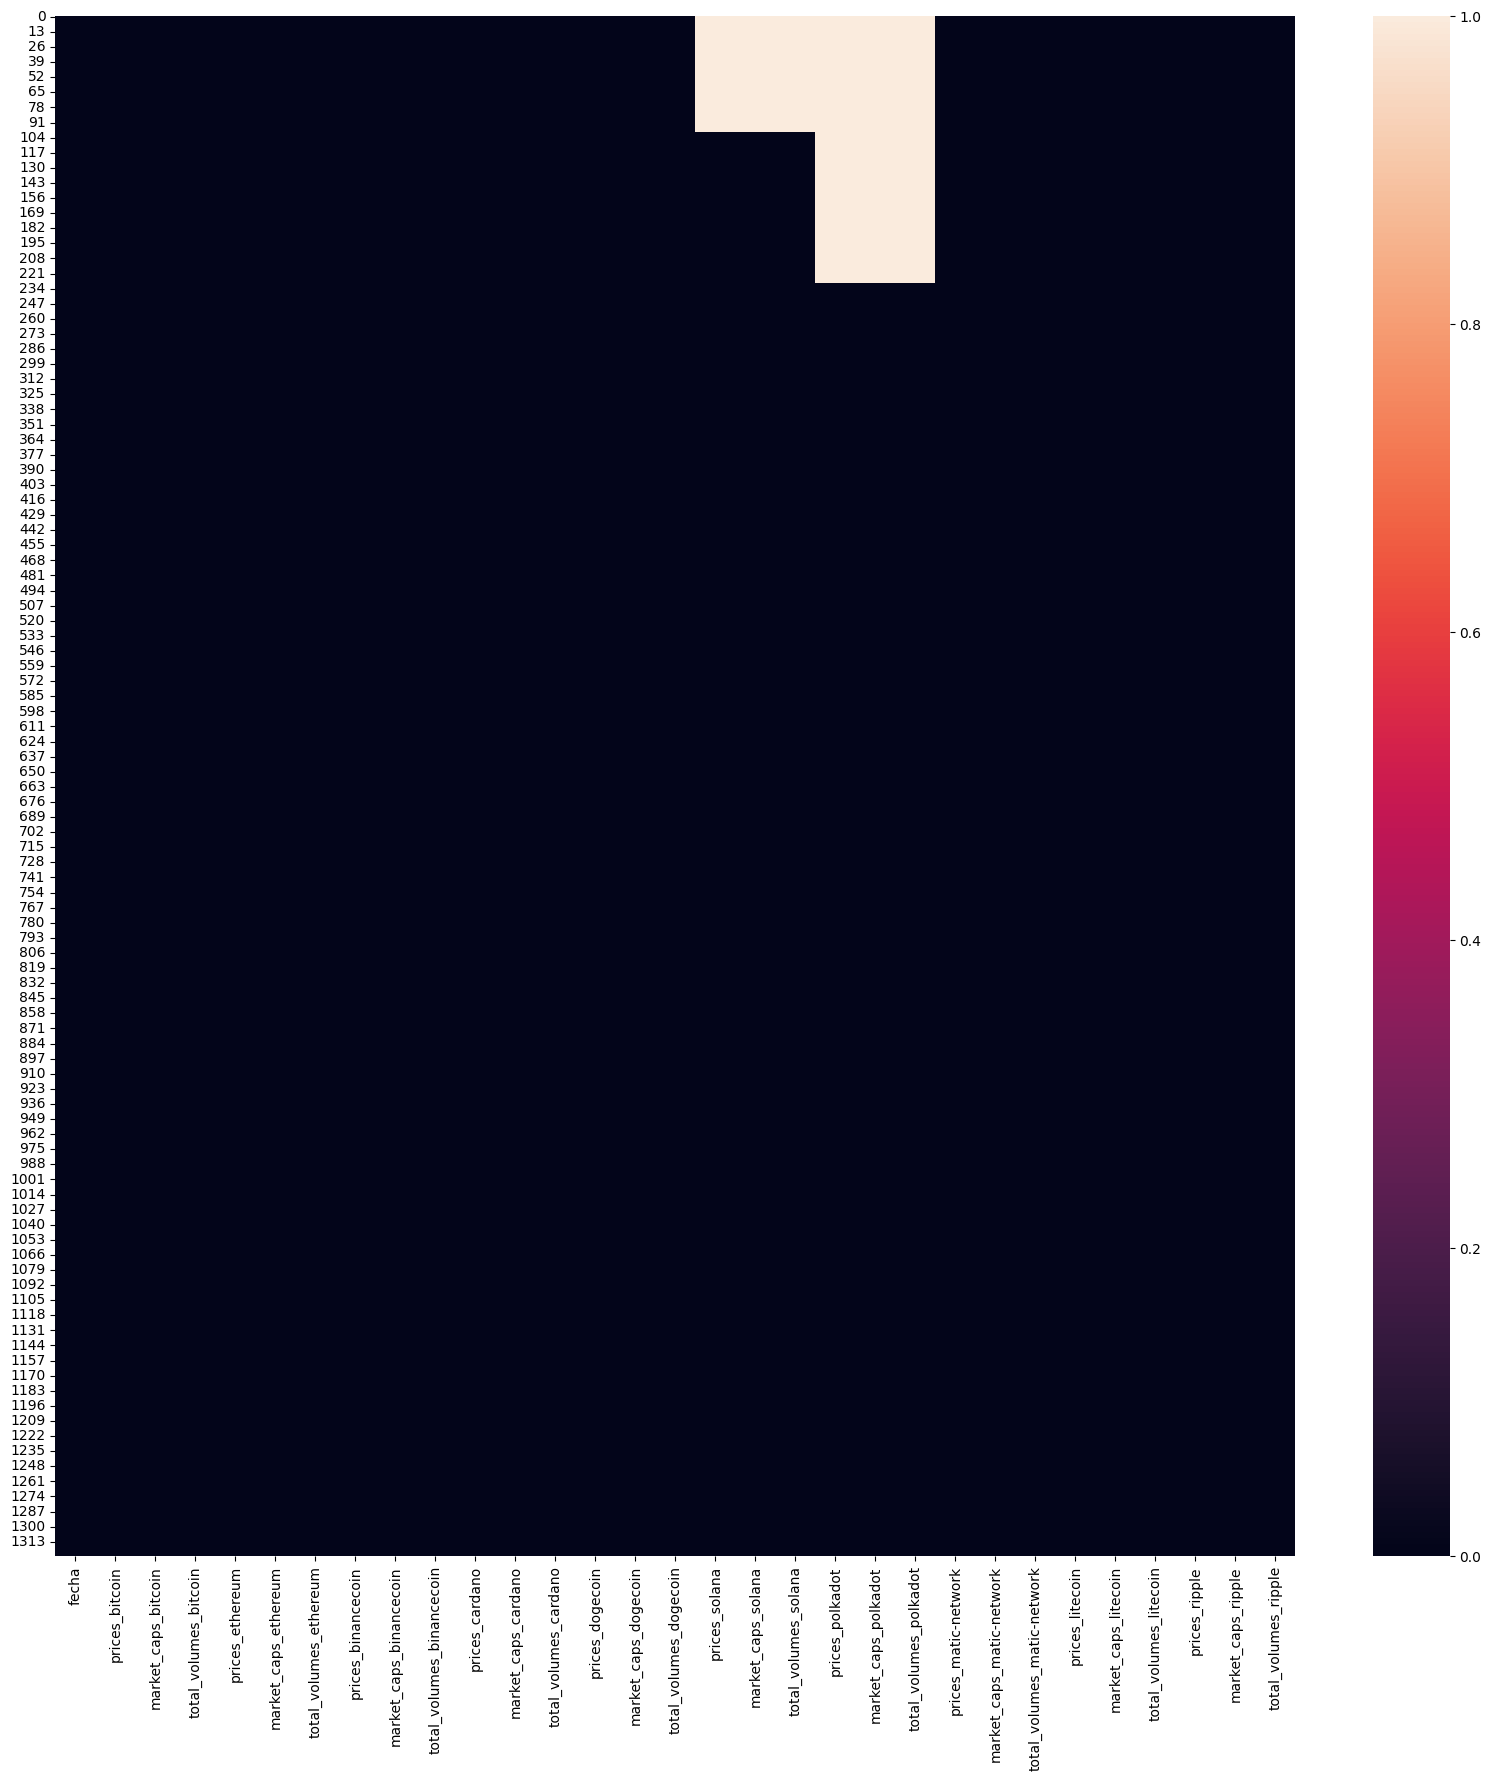

In [85]:
plt.figure(figsize=[20,20])
sns.heatmap(df_monedas.isnull()) 
plt.show()

Se puede observar (en el mapa de calor) y cuantificar con el '.info()' que las únicas monedas que tienen valores nulos son: `Solana` y `Polkadot`, esto debido a que la primera se lanzó el 10 de abril de 2020 y la segunda el 18 de agosto de 2020.

Por otra parte, también se deben considerar las estadísticas descriptivas (media, desviación estándar, valor mínimo y máximo, etc.) de cada columna, las cuales son:

In [86]:
df_monedas.describe()

,prices_bitcoin,market_caps_bitcoin,total_volumes_bitcoin,prices_ethereum,market_caps_ethereum,total_volumes_ethereum,prices_binancecoin,market_caps_binancecoin,total_volumes_binancecoin,prices_cardano,market_caps_cardano,total_volumes_cardano,prices_dogecoin,market_caps_dogecoin,total_volumes_dogecoin,prices_solana,market_caps_solana,total_volumes_solana,prices_polkadot,market_caps_polkadot,total_volumes_polkadot,prices_matic-network,market_caps_matic-network,total_volumes_matic-network,prices_litecoin,market_caps_litecoin,total_volumes_litecoin,prices_ripple,market_caps_ripple,total_volumes_ripple
count,1326.000000,1.326000e+03,1.326000e+03,1326.000000,1.326000e+03,1.326000e+03,1326.000000,1.326000e+03,1.326000e+03,1326.000000,1.326000e+03,1.326000e+03,1326.000000,1.326000e+03,1.326000e+03,1226.000000,1.226000e+03,1.226000e+03,1096.000000,1.096000e+03,1.096000e+03,1326.000000,1.326000e+03,1.326000e+03,1326.000000,1.326000e+03,1.326000e+03,1326.000000,1.326000e+03,1.326000e+03
mean,28479.293873,5.382681e+11,3.270812e+10,1702.983282,2.015844e+11,1.797304e+10,249.374462,3.999672e+10,1.383665e+09,0.673795,2.191735e+10,1.469779e+09,0.097473,1.291997e+10,1.535037e+09,45.480865,1.433107e+10,9.811620e+08,15.323116,1.608538e+10,8.636391e+08,0.760882,5.615884e+09,6.118867e+08,104.175072,7.128336e+09,2.445672e+09,0.535166,2.548376e+10,3.458484e+09
std,15686.524664,2.955009e+11,1.767093e+10,1161.601402,1.379870e+11,1.371723e+10,174.102793,2.847148e+10,1.783646e+09,0.658797,2.101643e+10,2.085861e+09,0.102556,1.337463e+10,3.933356e+09,56.217934,1.715620e+10,1.287801e+09,12.342747,1.238515e+10,9.623872e+08,0.645662,4.661344e+09,9.624945e+08,60.466838,4.055294e+09,2.652254e+09,0.315917,1.480946e+10,4.293733e+09
min,5032.501000,9.196280e+10,3.882362e+09,110.598000,1.195663e+10,2.179799e+09,9.401000,1.431388e+09,1.776448e+07,0.024000,7.335692e+08,4.883356e+07,0.001000,1.835883e+08,3.253959e+07,0.514000,4.171226e+06,5.489101e+05,2.872000,0.000000e+00,4.350072e+07,0.008000,2.241809e+07,4.683432e+06,30.281000,1.932963e+09,1.718595e+08,0.138000,6.028785e+09,2.316223e+08
25%,16539.353000,3.179397e+11,2.089959e+10,560.467750,6.387412e+10,9.435582e+09,30.310250,4.484481e+09,3.790961e+08,0.146500,4.564033e+09,2.930604e+08,0.004000,4.409117e+08,1.788447e+08,8.249750,2.176513e+09,1.131424e+08,5.494750,6.625235e+09,2.079159e+08,0.023000,9.223675e+07,4.256219e+07,57.086500,3.863954e+09,6.087789e+08,0.294000,1.320144e+10,1.328275e+09
50%,26833.526500,5.199698e+11,2.893909e+10,1664.451500,1.987075e+11,1.433857e+10,279.102000,4.475790e+10,8.050595e+08,0.393000,1.373243e+10,6.121266e+08,0.072000,9.897853e+09,4.938053e+08,24.427500,8.762482e+09,5.695233e+08,8.105000,8.928170e+09,4.704246e+08,0.794000,6.287506e+09,3.634925e+08,87.232000,6.295270e+09,1.596682e+09,0.450000,2.165717e+10,2.157734e+09
75%,40062.920750,7.564278e+11,4.032855e+10,2404.496750,2.803689e+11,2.169438e+10,352.124000,5.490088e+10,1.683815e+09,1.129500,3.623034e+10,1.582493e+09,0.138750,1.841150e+10,1.280826e+09,44.285000,1.457695e+10,1.360016e+09,23.035000,2.405709e+10,1.216917e+09,1.172500,9.300058e+09,7.540967e+08,138.090500,9.356010e+09,3.195740e+09,0.719250,3.481895e+10,3.761837e+09
max,67617.016000,1.278798e+12,1.788941e+11,4815.005000,5.716658e+11,1.409065e+11,675.099000,1.104412e+11,2.210352e+10,2.967000,9.500373e+10,1.743601e+10,0.682000,8.879477e+10,5.096065e+10,259.240000,7.742731e+10,1.614909e+10,54.143000,5.657831e+10,7.440268e+09,2.882000,1.975122e+10,1.086094e+10,384.672000,2.567776e+10,1.835039e+10,1.838000,8.438906e+10,6.246813e+10


Estas métricas se analizarán con más detalle más adelante, específicamente las columnas 'prices' y 'total_volumes' de cada moneda. Cabe aclarar que aunque la columna 'market_caps' es un indicador del dominio y la popularidad de las criptomonedas no se analizará directamente puesto que es producto del precio y el suministro circulante, es decir, está estrechamente ligada al precio (columna que sí se estudiará).  

>**`Precios (prices) de las monedas`**

Para analizar el comportamiento del precio de las monedas se extrae en un nuevo dataframe las columnas del precio junto con la columna de las fechas.

In [87]:
df_monedas_precios = df_monedas.iloc[:,[0,1,4,7,10,13,16,19,22,25,28]]
df_monedas_precios

,fecha,prices_bitcoin,prices_ethereum,prices_binancecoin,prices_cardano,prices_dogecoin,prices_solana,prices_polkadot,prices_matic-network,prices_litecoin,prices_ripple
0,2020-01-01,7193.755,130.485,13.686,0.033,0.002,NaN,NaN,0.015,41.606,0.193
1,2020-01-02,6963.853,127.045,13.007,0.033,0.002,NaN,NaN,0.015,39.414,0.187
2,2020-01-03,7300.347,133.703,13.603,0.034,0.002,NaN,NaN,0.015,41.991,0.192
3,2020-01-04,7351.377,134.137,13.795,0.034,0.002,NaN,NaN,0.015,42.781,0.193
4,2020-01-05,7349.972,135.006,14.006,0.034,0.002,NaN,NaN,0.015,43.227,0.194
...,...,...,...,...,...,...,...,...,...,...,...
1321,2023-08-14,29400.587,1843.513,240.358,0.290,0.075,25.148,4.986,0.679,82.043,0.635
1322,2023-08-15,29170.490,1826.913,236.607,0.282,0.071,23.876,4.811,0.639,79.255,0.609
1323,2023-08-16,28754.197,1809.460,232.095,0.275,0.067,22.846,4.664,0.624,74.443,0.589
1324,2023-08-17,26501.587,1675.862,217.796,0.254,0.061,21.647,4.422,0.572,64.664,0.505


Las métricas de estadística del dataframe anterior se muestran a continuación, las cuales se complementan con los códigos desarrollados inmediatamente después que reflejan la fecha en donde se dio el precio máximo y mínimo de cada criptomoneda.

In [88]:
df_monedas_precios.describe()

,prices_bitcoin,prices_ethereum,prices_binancecoin,prices_cardano,prices_dogecoin,prices_solana,prices_polkadot,prices_matic-network,prices_litecoin,prices_ripple
count,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1226.000000,1096.000000,1326.000000,1326.000000,1326.000000
mean,28479.293873,1702.983282,249.374462,0.673795,0.097473,45.480865,15.323116,0.760882,104.175072,0.535166
std,15686.524664,1161.601402,174.102793,0.658797,0.102556,56.217934,12.342747,0.645662,60.466838,0.315917
min,5032.501000,110.598000,9.401000,0.024000,0.001000,0.514000,2.872000,0.008000,30.281000,0.138000
25%,16539.353000,560.467750,30.310250,0.146500,0.004000,8.249750,5.494750,0.023000,57.086500,0.294000
50%,26833.526500,1664.451500,279.102000,0.393000,0.072000,24.427500,8.105000,0.794000,87.232000,0.450000
75%,40062.920750,2404.496750,352.124000,1.129500,0.138750,44.285000,23.035000,1.172500,138.090500,0.719250
max,67617.016000,4815.005000,675.099000,2.967000,0.682000,259.240000,54.143000,2.882000,384.672000,1.838000


En el `Bitcoin`: la media del precio es \$28479.29 con una desviación estándar de \$15686.52, el precio mínimo fue de \$5032.50 registrado el día '2020-03-16', y el máximo fue de \$67617.02 registrado el día '2021-11-08'.

En el `Ethereum`: la media del precio es \$1702.98 con una desviación estándar de \$1161.60, el precio mínimo fue de \$110.60 registrado el día '2020-03-12', y el máximo fue de \$4815.01 registrado el día '2021-11-08'.

En el `Binancecoin` (`BNB`): la media del precio es \$249.37 con una desviación estándar de \$174.10, el precio mínimo fue de \$9.40 registrado el día '2020-03-16', y el máximo fue de \$675.10 registrado el día '2021-05-03'.

En el `Cardano`: la media del precio es \$0.674 con una desviación estándar de \$0.659, el precio mínimo fue de \$0.024 registrado el día '2020-03-12', y el máximo fue de \$2.967 registrado el día '2021-09-03'.

En el `Dogecoin`: la media del precio es \$0.097 con una desviación estándar de \$0.103, el precio mínimo fue de \$0.001 registrado el día '2020-03-12', y el máximo fue de \$0.682 registrado el día '2021-05-07'.

En `Solana`: la media del precio es \$45.48 con una desviación estándar de \$56.22, el precio mínimo fue de \$0.514 registrado el día '2020-05-11', y el máximo fue de \$259.24 registrado el día '2021-11-06'.

En `Polkadot`: la media del precio es \$15.32 con una desviación estándar de \$12.34, el precio mínimo fue de \$2.87 registrado el día '2020-08-21', y el máximo fue de \$54.14 registrado el día '2021-11-04'.

En `Matic-Network` (`Polygon`): la media del precio es \$0.761 con una desviación estándar de \$0.646, el precio mínimo fue de \$0.008 registrado el día '2020-03-16', y el máximo fue de \$2.882 registrado el día '2021-12-26'.

En el `Litecoin`: la media del precio es \$104.18 con una desviación estándar de \$60.47, el precio mínimo fue de \$30.28 registrado el día '2020-03-12', y el máximo fue de \$384.67 registrado el día '2021-05-09'.

En el `Ripple` (`XRP`): la media del precio es \$0.535 con una desviación estándar de \$0.316, el precio mínimo fue de \$0.138 registrado el día '2020-03-12', y el máximo fue de \$1.838 registrado el día '2021-04-14'.

In [89]:
#Fechas de los precios máximos

dicc_precios_max = {}
for nombre_col, columna in df_monedas_precios.iloc[:,1:].items():
    dicc_precios_max[nombre_col] = [df_monedas_precios['fecha'][df_monedas_precios[nombre_col].idxmax()], columna.max()]

df_monedas_precios_max = pd.DataFrame(dicc_precios_max, index=['Fecha', 'Maximo'])
df_monedas_precios_max

,prices_bitcoin,prices_ethereum,prices_binancecoin,prices_cardano,prices_dogecoin,prices_solana,prices_polkadot,prices_matic-network,prices_litecoin,prices_ripple
Fecha,2021-11-08,2021-11-08,2021-05-03,2021-09-03,2021-05-07,2021-11-06,2021-11-04,2021-12-26,2021-05-09,2021-04-14
Maximo,67617.016,4815.005,675.099,2.967,0.682,259.24,54.143,2.882,384.672,1.838


Las cosas a destacar en cuanto a los precios máximos son: todos se dieron en el año 2021 siendo noviembre el mes con más ocurrencias (4); la fecha del precio más alto para el `Bitcoin` y el `Ethereum` es la misma (2021-11-08).

In [90]:
#Fechas de los precios mínimos

dicc_precios_min = {}
for nombre_col, columna in df_monedas_precios.iloc[:,1:].items():
    dicc_precios_min[nombre_col] = [df_monedas_precios['fecha'][df_monedas_precios[nombre_col].idxmin()], columna.min()]

df_monedas_precios_min = pd.DataFrame(dicc_precios_min, index=['Fecha', 'Mínimo'])
df_monedas_precios_min

,prices_bitcoin,prices_ethereum,prices_binancecoin,prices_cardano,prices_dogecoin,prices_solana,prices_polkadot,prices_matic-network,prices_litecoin,prices_ripple
Fecha,2020-03-16,2020-03-12,2020-03-16,2020-03-12,2020-03-12,2020-05-11,2020-08-21,2020-03-16,2020-03-12,2020-03-12
Mínimo,5032.501,110.598,9.401,0.024,0.001,0.514,2.872,0.008,30.281,0.138


En cuanto a los precios mínimos, las cosas a destacar son: todos se dieron en el año 2020 siendo marzo el mes con más ocurrencias (8); la fecha del precio más bajo para el `Bitcoin` y el `BNB` es la misma (2020-03-16), al igual que la del `Ethereum`, `Cardano`, `Dogecoin`, `Litecoin` y `Ripple` que fue el 2020-03-12.

Siguiendo con el análisis y con ayuda de un mapa de calor, pasamos al método estadístico llamado correlación lineal, que permite cuantificar la relación lineal (asociación) existente entre dos o más criptomonedas:

<Axes: >

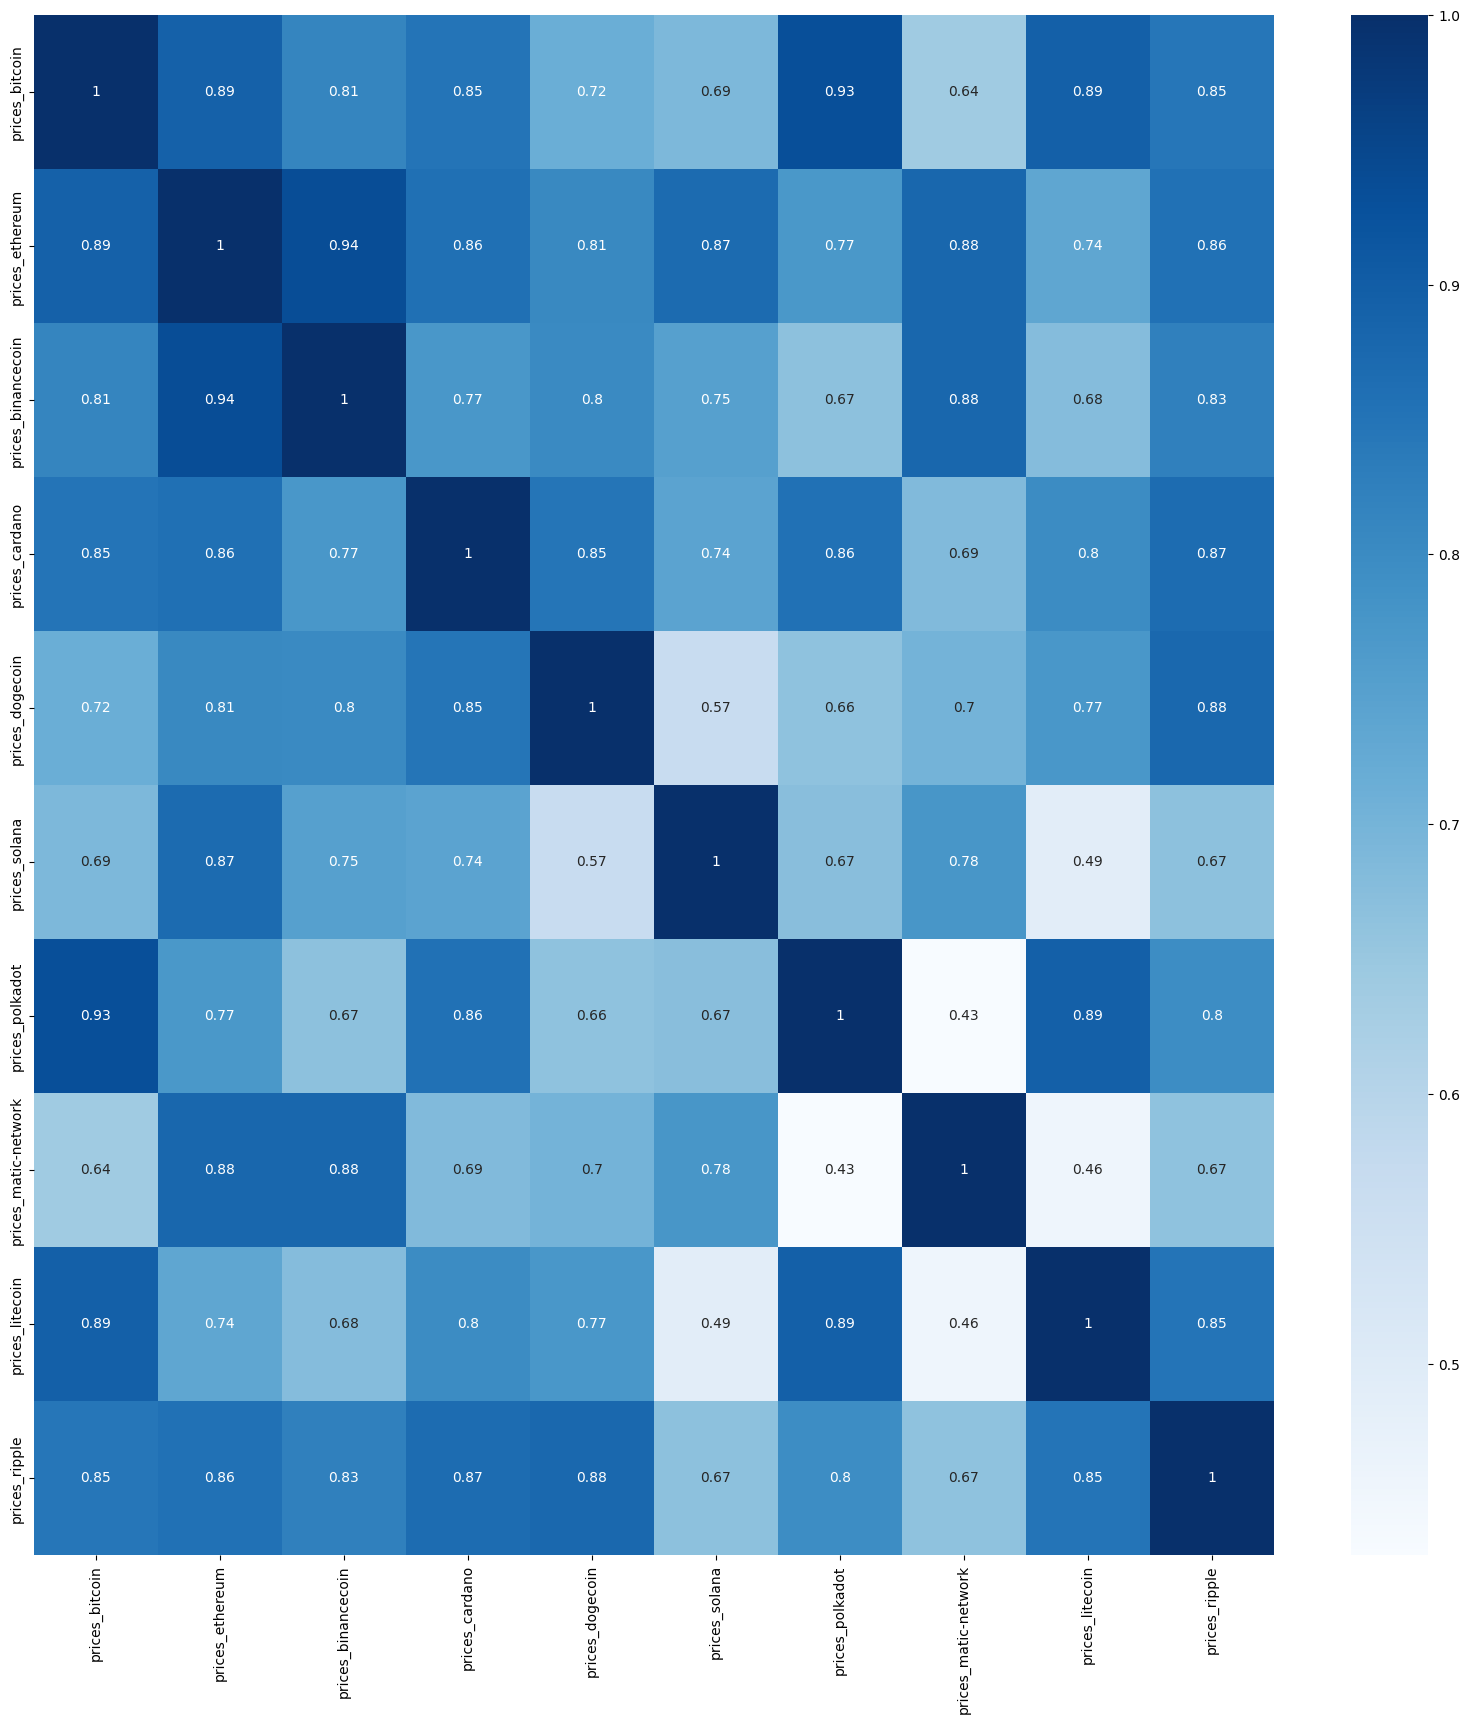

In [91]:
correlacion_prices = (df_monedas_precios.iloc[:,1:]).corr()
plt.figure(figsize=[20,20])
sns.heatmap(correlacion_prices, annot=True, cmap='Blues')

Se observa que las asociaciones más altas se dan entre: `Ethereum` y `Binancecoin` o `BNB` (de 0.94), y `Bitcoin` con `Polkadot` (de 0.93).

Además, existe una asociación muy alta de todas las criptomonedas con respecto al `Bitcoin`, excepto `Solana` y `Matic-network` o `Polygon` que tienen una asociación más moderada. La asociación más alta, como se mencionó anteriormente, es con `Polkadot` (de 0.93), luego con el `Ethereum` y `Litecoin` (de 0.89).

Con respecto al `Ethereum`, todas las criptomonedas están altamente asociadas sin excepciones. Las asociaciones más altas son con el `BNB` (de 0.94) y con el `Bitcoin` (de 0.89).

En cuanto a las asociaciones más bajas, de efecto mediano, se dan entre: `Polygon` y `Polkadot` (de 0.43), `Polygon` y `Litecoin` (de 0.46), `Solana` y `Litecoin` (de 0.49).

Lo anterior se puede constatar con los siguientes gráficos de 'precio' vs. 'fecha' donde las gráficas más similares o parecidas son aquellas cuya correlación lineal de criptomonedas es muy alta:

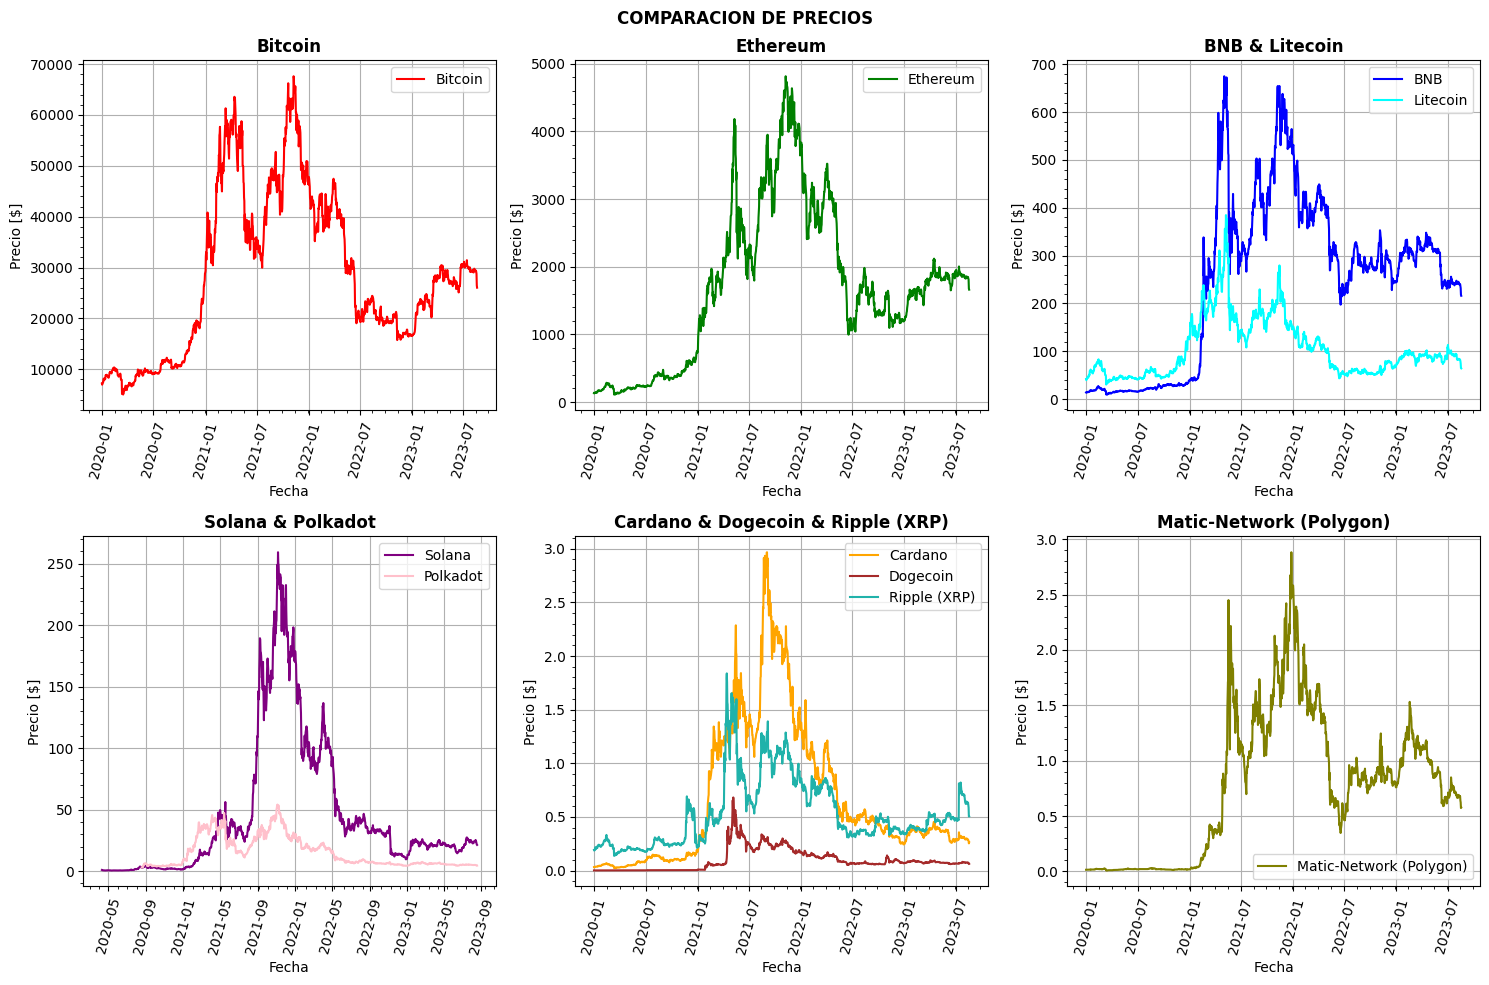

In [92]:
#Gráficas de 'precio' vs. 'fecha' de las criptomonedas

plt.figure(figsize=[15,10]) #tamaño de la figura
plt.suptitle('COMPARACION DE PRECIOS').set_fontweight('extra bold') #título de la gráfica

### Bitcoin ###
plt.subplot(231) #posición del subplot
plt.title('Bitcoin').set_fontweight('bold')  #título del subplot
plt.plot(df_monedas_precios['fecha'], df_monedas_precios['prices_bitcoin'], label='Bitcoin', color='red')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### Ethereum ###
plt.subplot(232)
plt.title('Ethereum').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'], df_monedas_precios['prices_ethereum'], label='Ethereum', color='green')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### BNB & Litecoin ###
plt.subplot(233)
plt.title('BNB & Litecoin').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'], df_monedas_precios['prices_binancecoin'], label='BNB', color='blue')
plt.plot(df_monedas_precios['fecha'], df_monedas_precios['prices_litecoin'], label='Litecoin', color='cyan')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### Solana & Polkadot ###
plt.subplot(234)
plt.title('Solana & Polkadot').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'], df_monedas_precios['prices_solana'], label='Solana', color='purple')
plt.plot(df_monedas_precios['fecha'], df_monedas_precios['prices_polkadot'], label='Polkadot', color='pink')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### Cardano & Dogecoin & Ripple (XRP) ###
plt.subplot(235)
plt.title('Cardano & Dogecoin & Ripple (XRP)').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'], df_monedas_precios['prices_cardano'], label='Cardano', color='orange')
plt.plot(df_monedas_precios['fecha'], df_monedas_precios['prices_dogecoin'], label='Dogecoin', color='brown')
plt.plot(df_monedas_precios['fecha'], df_monedas_precios['prices_ripple'], label='Ripple (XRP)', color='lightseagreen')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### Matic-Network (Polygon) ###
plt.subplot(236)
plt.title('Matic-Network (Polygon)').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'], df_monedas_precios['prices_matic-network'], label='Matic-Network (Polygon)', color='olive')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.tight_layout() #ajuste del relleno (entre y alrededor) de los subplots

En los gráficos anteriores se observa que todas las criptomonedas han aumentado de precio si se le compara el que tenían a inicios del año 2020 con el precio actual.

Por otra parte, se muestra a continuación un 'boxplot' o diagrama de caja y bigotes para cada criptomoneda:

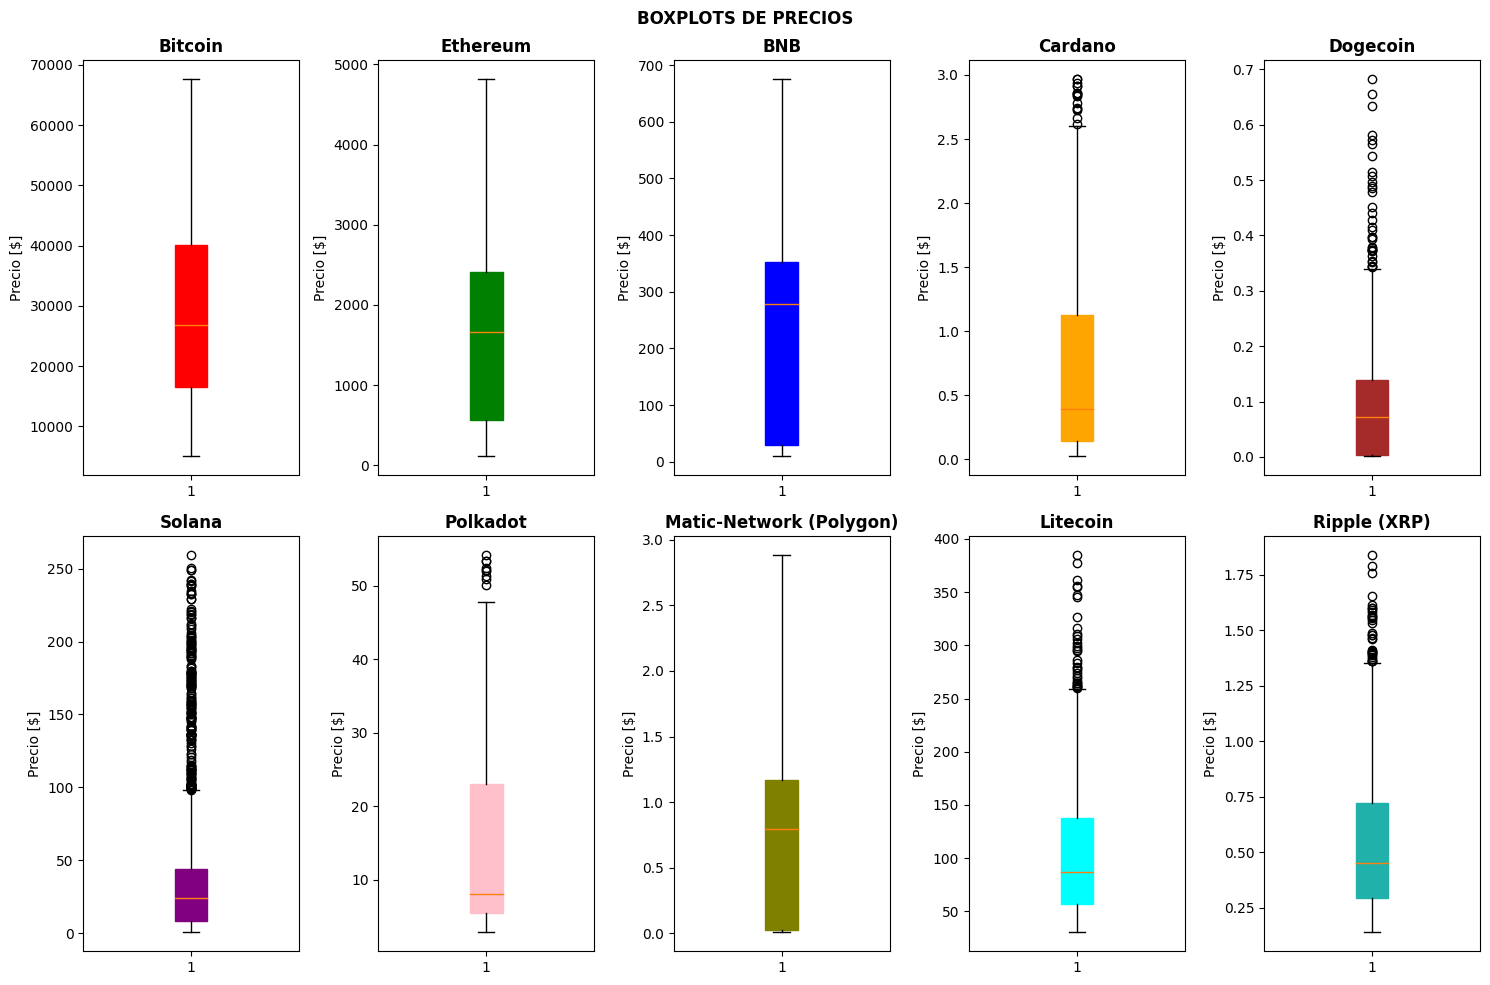

In [93]:
#Diagrama de caja y bigotes (Boxplot) para cada criptomoneda

fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=5) #tamaño de la figura y cantidad de subplots
fig.suptitle('BOXPLOTS DE PRECIOS').set_fontweight('extra bold') #título de la gráfica

ax_actual = 0
colores = ['red','green','blue','orange','brown','purple','pink','olive','cyan','lightseagreen']
columnas = ['Bitcoin', 'Ethereum', 'BNB', 'Cardano', 'Dogecoin', 'Solana', 'Polkadot', 'Matic-Network (Polygon)', 'Litecoin', 'Ripple (XRP)']

for nombre_col, columna in df_monedas_precios.iloc[:,1:].items():

    ax = fig.axes[ax_actual]
    ax.boxplot(columna.dropna(), patch_artist=True, boxprops=dict(facecolor=colores[ax_actual], color=colores[ax_actual])) #se exceptúan los valores nulos
    ax.set_title(columnas[ax_actual]).set_fontweight('bold')
    ax.set_ylabel('Precio [$]')

    ax_actual += 1

plt.tight_layout() #ajuste del relleno (entre y alrededor) de los subplots

Se aprecian muchos valores atípicos en la mayoría de criptomonedas a excepción de `Bitcoin`, `Ethereum`, `BNB` y `Polygon`. En el diagrama de `Solana` se observan muchos outliers en un rango muy amplio pero esto se debe a la subida y bajada de precio (volatilidad) que genera picos de valores. Este mismo análisis cumple para las demás monedas.

>**`Volumen (total_volumes) de las monedas`**

Para analizar ahora el comportamiento del volumen de las monedas se extrae en un nuevo dataframe las columnas del volumen junto con la columna de las fechas.

In [94]:
df_monedas_volumen = df_monedas.iloc[:,[0,3,6,9,12,15,18,21,24,27,30]]
df_monedas_volumen

,fecha,total_volumes_bitcoin,total_volumes_ethereum,total_volumes_binancecoin,total_volumes_cardano,total_volumes_dogecoin,total_volumes_solana,total_volumes_polkadot,total_volumes_matic-network,total_volumes_litecoin,total_volumes_ripple
0,2020-01-01,1.812352e+10,6.623732e+09,1.847091e+08,7.486784e+07,3.857691e+07,NaN,NaN,2.050431e+07,1.979757e+09,1.043386e+09
1,2020-01-02,2.031319e+10,6.497298e+09,1.573566e+08,6.383528e+07,4.608031e+07,NaN,NaN,2.616516e+07,1.678103e+09,1.082069e+09
2,2020-01-03,3.101578e+10,9.655245e+09,1.772397e+08,7.916796e+07,4.086374e+07,NaN,NaN,1.485333e+07,2.333782e+09,1.276806e+09
3,2020-01-04,2.061164e+10,6.958394e+09,1.699075e+08,7.791814e+07,4.619690e+07,NaN,NaN,1.053623e+07,2.085469e+09,9.874215e+08
4,2020-01-05,2.192922e+10,7.260645e+09,1.834075e+08,4.883356e+07,3.253959e+07,NaN,NaN,8.289301e+06,2.498423e+09,1.151984e+09
...,...,...,...,...,...,...,...,...,...,...,...
1321,2023-08-14,1.240836e+10,4.495325e+09,3.232128e+08,1.298745e+08,4.339586e+08,3.880259e+08,9.157987e+07,1.667570e+08,3.161944e+08,9.673053e+08
1322,2023-08-15,1.152340e+10,4.416612e+09,4.801982e+08,1.741227e+08,4.857363e+08,4.525215e+08,1.060911e+08,2.496742e+08,5.701264e+08,1.200449e+09
1323,2023-08-16,1.480998e+10,6.472231e+09,5.180758e+08,2.347988e+08,5.408913e+08,4.952949e+08,1.293041e+08,3.271599e+08,9.010253e+08,1.563956e+09
1324,2023-08-17,2.996559e+10,2.096277e+10,9.462674e+08,3.406436e+08,8.754130e+08,6.564125e+08,2.056949e+08,4.099953e+08,1.128829e+09,2.195107e+09


Las métricas de estadística del dataframe anterior se muestran a continuación, las cuales se complementan con los códigos desarrollados inmediatamente después que reflejan la fecha en donde se dio el volumen máximo y mínimo de cada criptomoneda.

In [95]:
df_monedas_volumen.describe()

,total_volumes_bitcoin,total_volumes_ethereum,total_volumes_binancecoin,total_volumes_cardano,total_volumes_dogecoin,total_volumes_solana,total_volumes_polkadot,total_volumes_matic-network,total_volumes_litecoin,total_volumes_ripple
count,1.326000e+03,1.326000e+03,1.326000e+03,1.326000e+03,1.326000e+03,1.226000e+03,1.096000e+03,1.326000e+03,1.326000e+03,1.326000e+03
mean,3.270812e+10,1.797304e+10,1.383665e+09,1.469779e+09,1.535037e+09,9.811620e+08,8.636391e+08,6.118867e+08,2.445672e+09,3.458484e+09
std,1.767093e+10,1.371723e+10,1.783646e+09,2.085861e+09,3.933356e+09,1.287801e+09,9.623872e+08,9.624945e+08,2.652254e+09,4.293733e+09
min,3.882362e+09,2.179799e+09,1.776448e+07,4.883356e+07,3.253959e+07,5.489101e+05,4.350072e+07,4.683432e+06,1.718595e+08,2.316223e+08
25%,2.089959e+10,9.435582e+09,3.790961e+08,2.930604e+08,1.788447e+08,1.131424e+08,2.079159e+08,4.256219e+07,6.087789e+08,1.328275e+09
50%,2.893909e+10,1.433857e+10,8.050595e+08,6.121266e+08,4.938053e+08,5.695233e+08,4.704246e+08,3.634925e+08,1.596682e+09,2.157734e+09
75%,4.032855e+10,2.169438e+10,1.683815e+09,1.582493e+09,1.280826e+09,1.360016e+09,1.216917e+09,7.540967e+08,3.195740e+09,3.761837e+09
max,1.788941e+11,1.409065e+11,2.210352e+10,1.743601e+10,5.096065e+10,1.614909e+10,7.440268e+09,1.086094e+10,1.835039e+10,6.246813e+10


En el `Bitcoin`: el volumen mínimo se registró el día '2023-05-20' y el máximo el día '2021-01-03'.

En el `Ethereum`: el volumen mínimo se registró el día '2023-01-01' y el máximo el día '2021-01-03'.

En el `Binancecoin` (`BNB`): el volumen mínimo se registró el día '2022-12-31' y el máximo el día '2021-02-19'.

En el `Cardano`: el volumen mínimo se registró el día '2020-01-05' y el máximo el día '2021-02-27'.

En el `Dogecoin`: el volumen mínimo se registró el día '2020-01-05' y el máximo el día '2021-04-16'.

En `Solana`: el volumen mínimo se registró el día '2020-05-14' y el máximo el día a '2021-09-07'.

En `Polkadot`: el volumen mínimo se registró el día '2022-12-24' y el máximo el día '2021-05-19'.

En `Matic-Network` (`Polygon`): el volumen mínimo se registró el día '2020-10-18' y el máximo el día '2021-05-19'.

En el `Litecoin`: el volumen mínimo se registró el día '2022-10-01' y el máximo el día '2022-05-13'.

En el `Ripple` (`XRP`): el volumen mínimo se registró el día '2022-12-24' y el máximo el día '2022-07-17'.

In [96]:
#Fechas de los volúmenes máximos

dicc_volumen_max = {}
for nombre_col, columna in df_monedas_volumen.iloc[:,1:].items():
    dicc_volumen_max[nombre_col] = [df_monedas_volumen['fecha'][df_monedas_volumen[nombre_col].idxmax()], columna.max()]

df_monedas_volumen_max = pd.DataFrame(dicc_volumen_max, index=['Fecha', 'Maximo'])
df_monedas_volumen_max

,total_volumes_bitcoin,total_volumes_ethereum,total_volumes_binancecoin,total_volumes_cardano,total_volumes_dogecoin,total_volumes_solana,total_volumes_polkadot,total_volumes_matic-network,total_volumes_litecoin,total_volumes_ripple
Fecha,2021-01-03,2021-01-03,2021-02-19,2021-02-27,2021-04-16,2021-09-07,2021-05-19,2021-05-19,2022-05-13,2022-07-17
Maximo,178894068361.353119,140906534190.58786,22103516567.70705,17436012662.324448,50960650646.950821,16149087501.300968,7440268038.096745,10860942519.364164,18350385301.592522,62468131981.565353


Las cosas a destacar en cuanto a los volúmenes máximos son: todos se dieron en el año 2021 siendo mayo el mes con más ocurrencias (3); el volumen más alto de transacciones para el `Bitcoin` y el `Ethereum` ocurrió en la misma fecha (2021-01-03), del mismo modo el volumen de `Polkadot` y `Polygon` (2021-05-19).

In [97]:
#Fechas de los volúmenes mínimos

dicc_volumen_min = {}
for nombre_col, columna in df_monedas_volumen.iloc[:,1:].items():
    dicc_volumen_min[nombre_col] = [df_monedas_volumen['fecha'][df_monedas_volumen[nombre_col].idxmin()], columna.min()]

df_monedas_volumen_min = pd.DataFrame(dicc_volumen_min, index=['Fecha', 'Mínimo'])
df_monedas_volumen_min

,total_volumes_bitcoin,total_volumes_ethereum,total_volumes_binancecoin,total_volumes_cardano,total_volumes_dogecoin,total_volumes_solana,total_volumes_polkadot,total_volumes_matic-network,total_volumes_litecoin,total_volumes_ripple
Fecha,2023-05-20,2023-01-01,2022-12-31,2020-01-05,2020-01-05,2020-05-14,2022-12-24,2020-10-18,2022-10-01,2022-12-24
Mínimo,3882362454.219783,2179799161.038537,17764481.568582,48833556.383982,32539590.819855,548910.111112,43500721.620467,4683431.843982,171859465.874655,231622343.957664


En cuanto a los volúmenes mínimos, las cosas a destacar son: la mayoría de criptomonedas (8) lo obtuvo a finales o principio de año (enero, octubre y diciembre) excepto `Bitcoin`, y `Solana` que recién se había lanzado; la fecha del volumen más bajo para el `Cardano` y el `Dogecoin` es la misma (2020-01-05), al igual que la del `Polkadot` y `XRP` que fue el 2022-12-24.

Ahora, con ayuda de un mapa de calor y la correlación lineal, se analiza la asociación existente entre dos o más criptomonedas:

<Axes: >

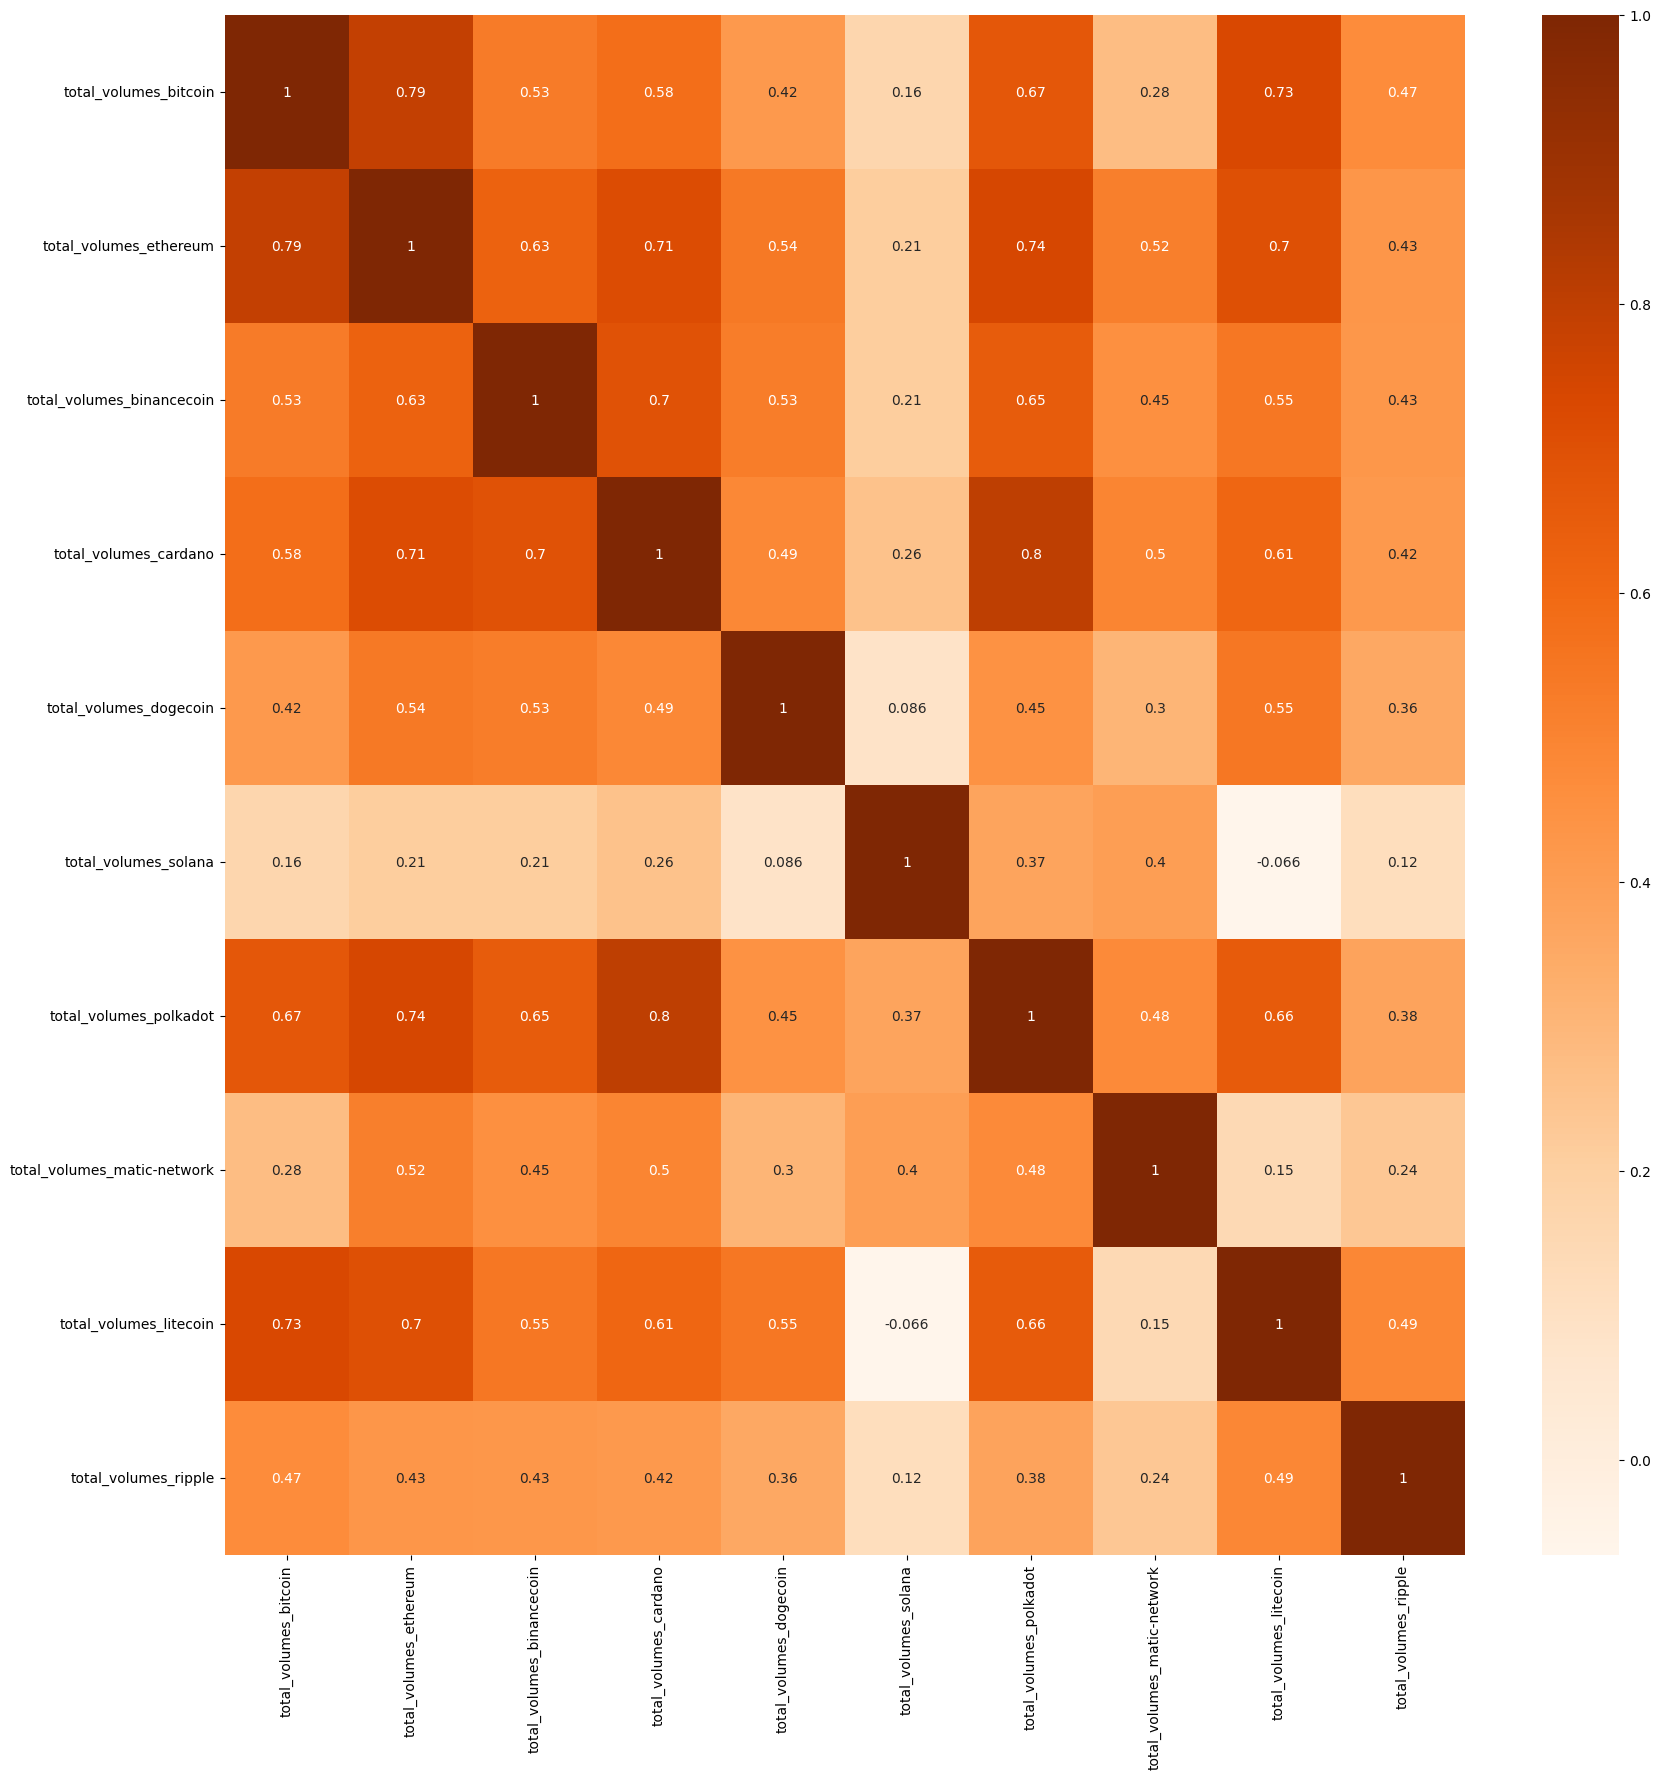

In [98]:
correlacion_volumen = (df_monedas_volumen.iloc[:,1:]).corr()
plt.figure(figsize=[20,20])
sns.heatmap(correlacion_volumen, annot=True, cmap='Oranges')

Se observa que existen diferentes tipos de correlaciones que van desde positivas altas hasta casi nulas y negativas.

La asociación más alta, que es de 0.8, se da entre `Polkadot` y `Cardano` seguida por la del `Bitcoin` con el `Ethereum` de 0.79.

En cuanto a las asociaciónes casi nulas, existen varias, y todas se dan con la criptomoneda `Solana`, incluyendo la relación negativa de -0.066 de esta con `Litecoin`.  

Lo anterior se puede constatar con los siguientes gráficos de 'volumen' vs. 'fecha':

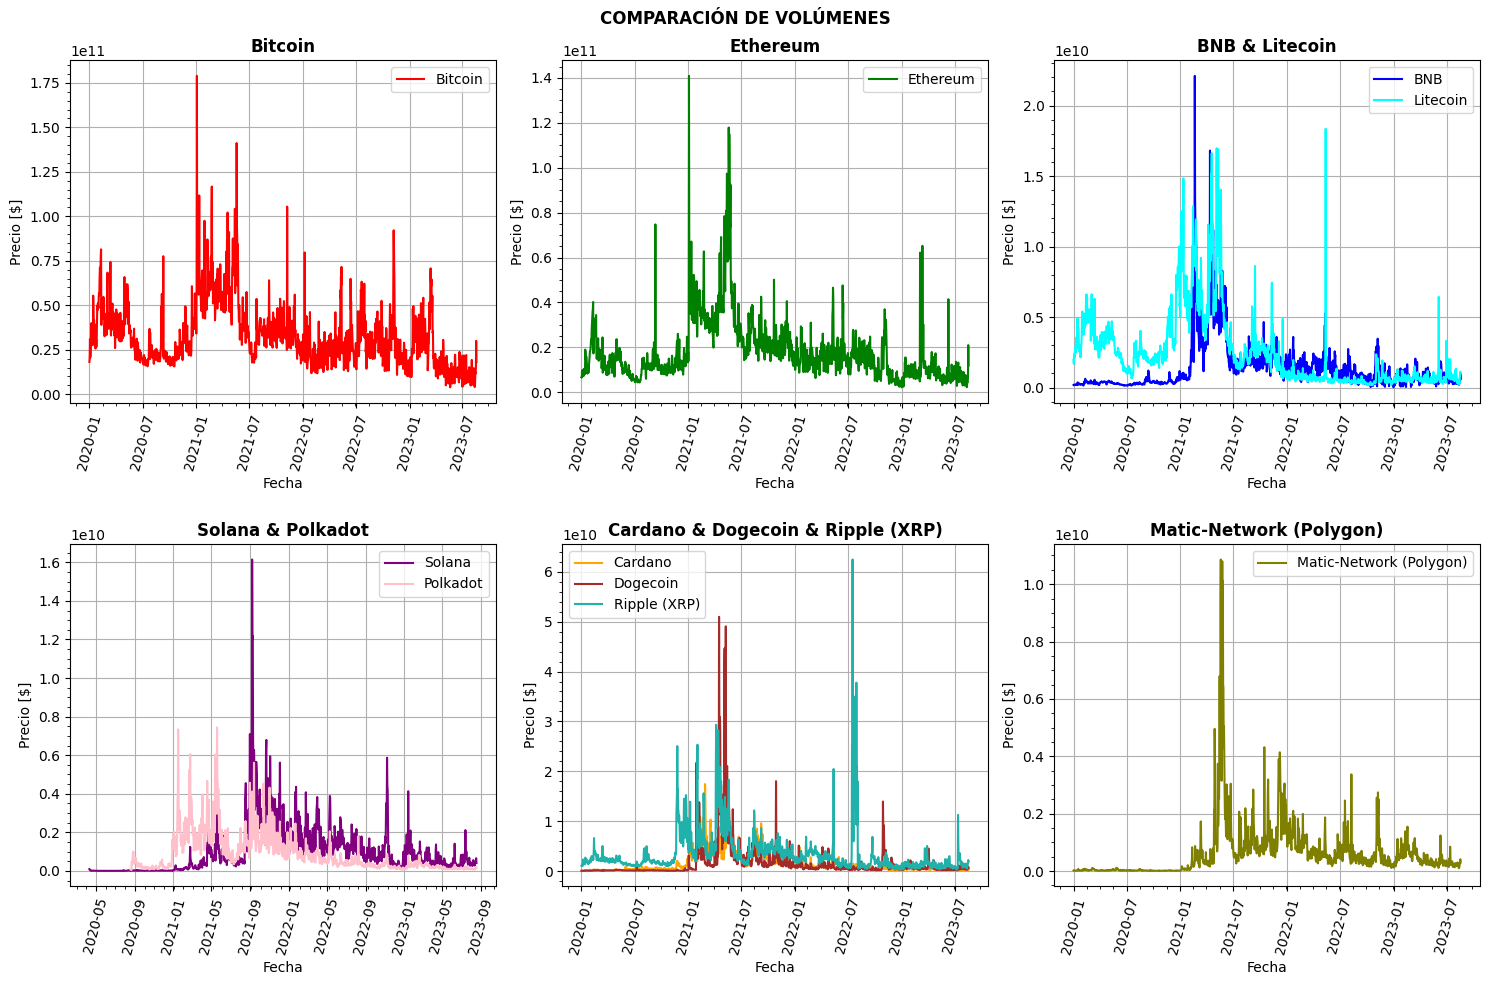

In [99]:
#Gráficas de 'volumen' vs. 'fecha' de las criptomonedas

plt.figure(figsize=[15,10]) #tamaño de la figura
plt.suptitle('COMPARACIÓN DE VOLÚMENES').set_fontweight('extra bold') #título de la gráfico

### Bitcoin ###
plt.subplot(231)
plt.title('Bitcoin').set_fontweight('bold') #titulo del subplot
plt.plot(df_monedas_volumen['fecha'], df_monedas_volumen['total_volumes_bitcoin'], label='Bitcoin', color='red')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### Ethereum ###
plt.subplot(232)
plt.title('Ethereum').set_fontweight('bold')
plt.plot(df_monedas_volumen['fecha'], df_monedas_volumen['total_volumes_ethereum'], label='Ethereum', color='green')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### Binancecoin (BNB) & Litecoin ###
plt.subplot(233)
plt.title('BNB & Litecoin').set_fontweight('bold')
plt.plot(df_monedas_volumen['fecha'], df_monedas_volumen['total_volumes_binancecoin'], label='BNB', color='blue')
plt.plot(df_monedas_volumen['fecha'], df_monedas_volumen['total_volumes_litecoin'], label='Litecoin', color='cyan')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()


### Solana & Polkadot ###
plt.subplot(234)
plt.title('Solana & Polkadot').set_fontweight('bold')
plt.plot(df_monedas_volumen['fecha'], df_monedas_volumen['total_volumes_solana'], label='Solana', color='purple')
plt.plot(df_monedas_volumen['fecha'], df_monedas_volumen['total_volumes_polkadot'], label='Polkadot', color='pink')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### Cardano & Dogecoin & Ripple (XRP) ###
plt.subplot(235)
plt.title('Cardano & Dogecoin & Ripple (XRP)').set_fontweight('bold')
plt.plot(df_monedas_volumen['fecha'], df_monedas_volumen['total_volumes_cardano'], label='Cardano', color='orange')
plt.plot(df_monedas_volumen['fecha'], df_monedas_volumen['total_volumes_dogecoin'], label='Dogecoin', color='brown')
plt.plot(df_monedas_volumen['fecha'], df_monedas_volumen['total_volumes_ripple'], label='Ripple (XRP)', color='lightseagreen')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### Matic-Network (Polygon) ###
plt.subplot(236)
plt.title('Matic-Network (Polygon)').set_fontweight('bold')
plt.plot(df_monedas_volumen['fecha'], df_monedas_volumen['total_volumes_matic-network'], label='Matic-Network (Polygon)', color='olive')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.tight_layout() #ajuste del relleno (entre y alrededor) de los subplots

Para terminar, se muestra un 'boxplot' o diagrama de caja y bigotes para cada criptomoneda:

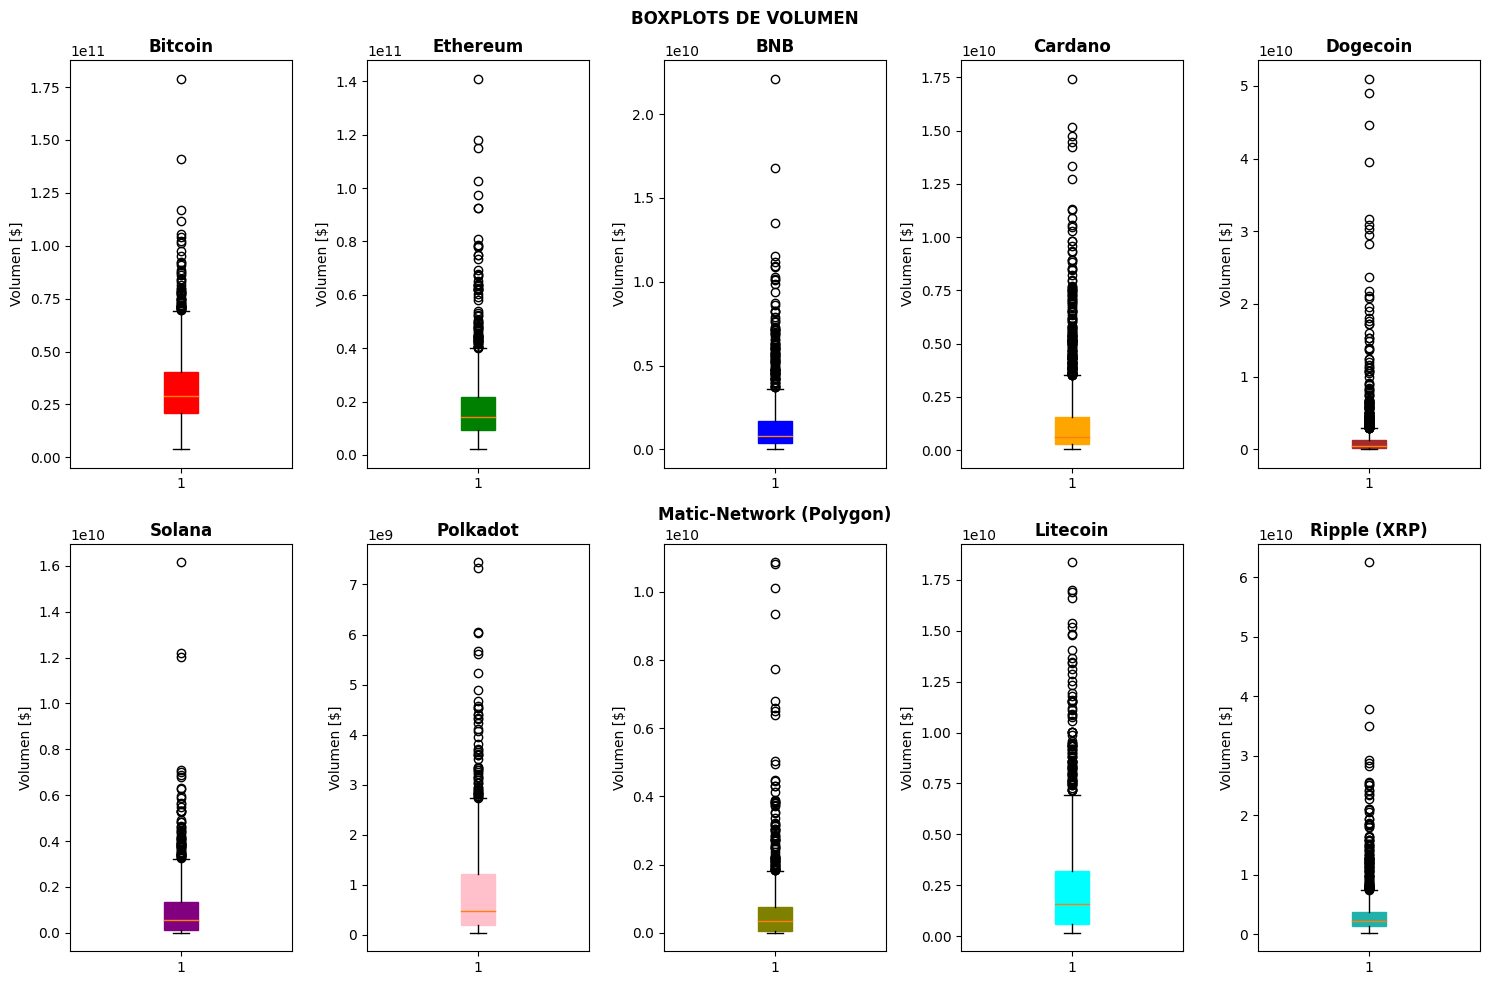

In [100]:
#Diagrama de caja y bigotes (Boxplot) para cada criptomoneda

fig, ax = plt.subplots(figsize=(15,10), nrows=2, ncols=5) #tamaño de la figura y cantidad de subplots
fig.suptitle('BOXPLOTS DE VOLUMEN').set_fontweight('extra bold') #título de la gráfica

ax_actual = 0
colores = ['red','green','blue','orange','brown','purple','pink','olive','cyan','lightseagreen']
columnas = ['Bitcoin', 'Ethereum', 'BNB', 'Cardano', 'Dogecoin', 'Solana', 'Polkadot', 'Matic-Network (Polygon)', 'Litecoin', 'Ripple (XRP)']

for nombre_col, columna in df_monedas_volumen.iloc[:,1:].items():

    ax = fig.axes[ax_actual]
    ax.boxplot(columna.dropna(), patch_artist=True, boxprops=dict(facecolor=colores[ax_actual], color=colores[ax_actual])) #se exceptúan los valores nulos
    ax.set_title(columnas[ax_actual]).set_fontweight('bold')
    ax.set_ylabel('Volumen [$]')

    ax_actual += 1

plt.tight_layout() #ajuste del relleno (entre y alrededor) de los subplots

Se aprecian muchos valores atípicos en todas las criptomonedas. Estos outliers representan altos volúmenes de transacciones o inversiones en ciertos momentos lo que genera picos de valores.

>**`Análisis de precios de las criptomonedas por año`**

Para este análisis se usa el mismo dataframe del estudio de precios pero anexándole una nueva columna llamada 'fecha_año' que es la extracción del año de la columna 'fecha' con el fin de usar este como filtro de las gráficas.

Dicho análisis se hace con la ayuda de la correlación lineal y mapa de calor y de graficas de precios para cada año.

In [101]:
df_monedas_precios.insert(loc=1, column='fecha_año', value= df_monedas_precios.loc[:,'fecha'].apply(lambda x: x.year))
df_monedas_precios

,fecha,fecha_año,prices_bitcoin,prices_ethereum,prices_binancecoin,prices_cardano,prices_dogecoin,prices_solana,prices_polkadot,prices_matic-network,prices_litecoin,prices_ripple
0,2020-01-01,2020,7193.755,130.485,13.686,0.033,0.002,NaN,NaN,0.015,41.606,0.193
1,2020-01-02,2020,6963.853,127.045,13.007,0.033,0.002,NaN,NaN,0.015,39.414,0.187
2,2020-01-03,2020,7300.347,133.703,13.603,0.034,0.002,NaN,NaN,0.015,41.991,0.192
3,2020-01-04,2020,7351.377,134.137,13.795,0.034,0.002,NaN,NaN,0.015,42.781,0.193
4,2020-01-05,2020,7349.972,135.006,14.006,0.034,0.002,NaN,NaN,0.015,43.227,0.194
...,...,...,...,...,...,...,...,...,...,...,...,...
1321,2023-08-14,2023,29400.587,1843.513,240.358,0.290,0.075,25.148,4.986,0.679,82.043,0.635
1322,2023-08-15,2023,29170.490,1826.913,236.607,0.282,0.071,23.876,4.811,0.639,79.255,0.609
1323,2023-08-16,2023,28754.197,1809.460,232.095,0.275,0.067,22.846,4.664,0.624,74.443,0.589
1324,2023-08-17,2023,26501.587,1675.862,217.796,0.254,0.061,21.647,4.422,0.572,64.664,0.505


<mark>Para el año 2020:

In [102]:
df_monedas_precios[df_monedas_precios['fecha_año'] == 2020].describe()

,fecha_año,prices_bitcoin,prices_ethereum,prices_binancecoin,prices_cardano,prices_dogecoin,prices_solana,prices_polkadot,prices_matic-network,prices_litecoin,prices_ripple
count,366.0,366.000000,366.000000,366.000000,366.000000,366.000000,266.000000,136.000000,366.000000,366.000000,366.00000
mean,2020.0,11111.837148,307.305801,21.322175,0.086669,0.002760,1.696774,4.778618,0.018639,56.197784,0.25812
std,0.0,4312.769754,144.489792,6.261462,0.041567,0.000708,1.004759,0.852190,0.004009,18.252655,0.10492
min,2020.0,5032.501000,110.598000,9.401000,0.024000,0.001000,0.514000,2.872000,0.008000,30.281000,0.13800
25%,2020.0,8880.425000,200.337000,16.395000,0.050000,0.002000,0.696500,4.249750,0.016000,44.067750,0.19825
50%,2020.0,9716.022500,244.232500,19.637000,0.086000,0.003000,1.593500,4.650500,0.019000,48.815000,0.23600
75%,2020.0,11675.369750,387.932500,27.587500,0.118000,0.003000,2.311750,5.196750,0.021000,61.134750,0.27175
max,2020.0,29022.418000,752.856000,38.838000,0.193000,0.005000,4.794000,9.361000,0.030000,130.639000,0.69200


Se observa una gran diferencia entre el valor mínimo y máximo en todas las monedas.

<Axes: >

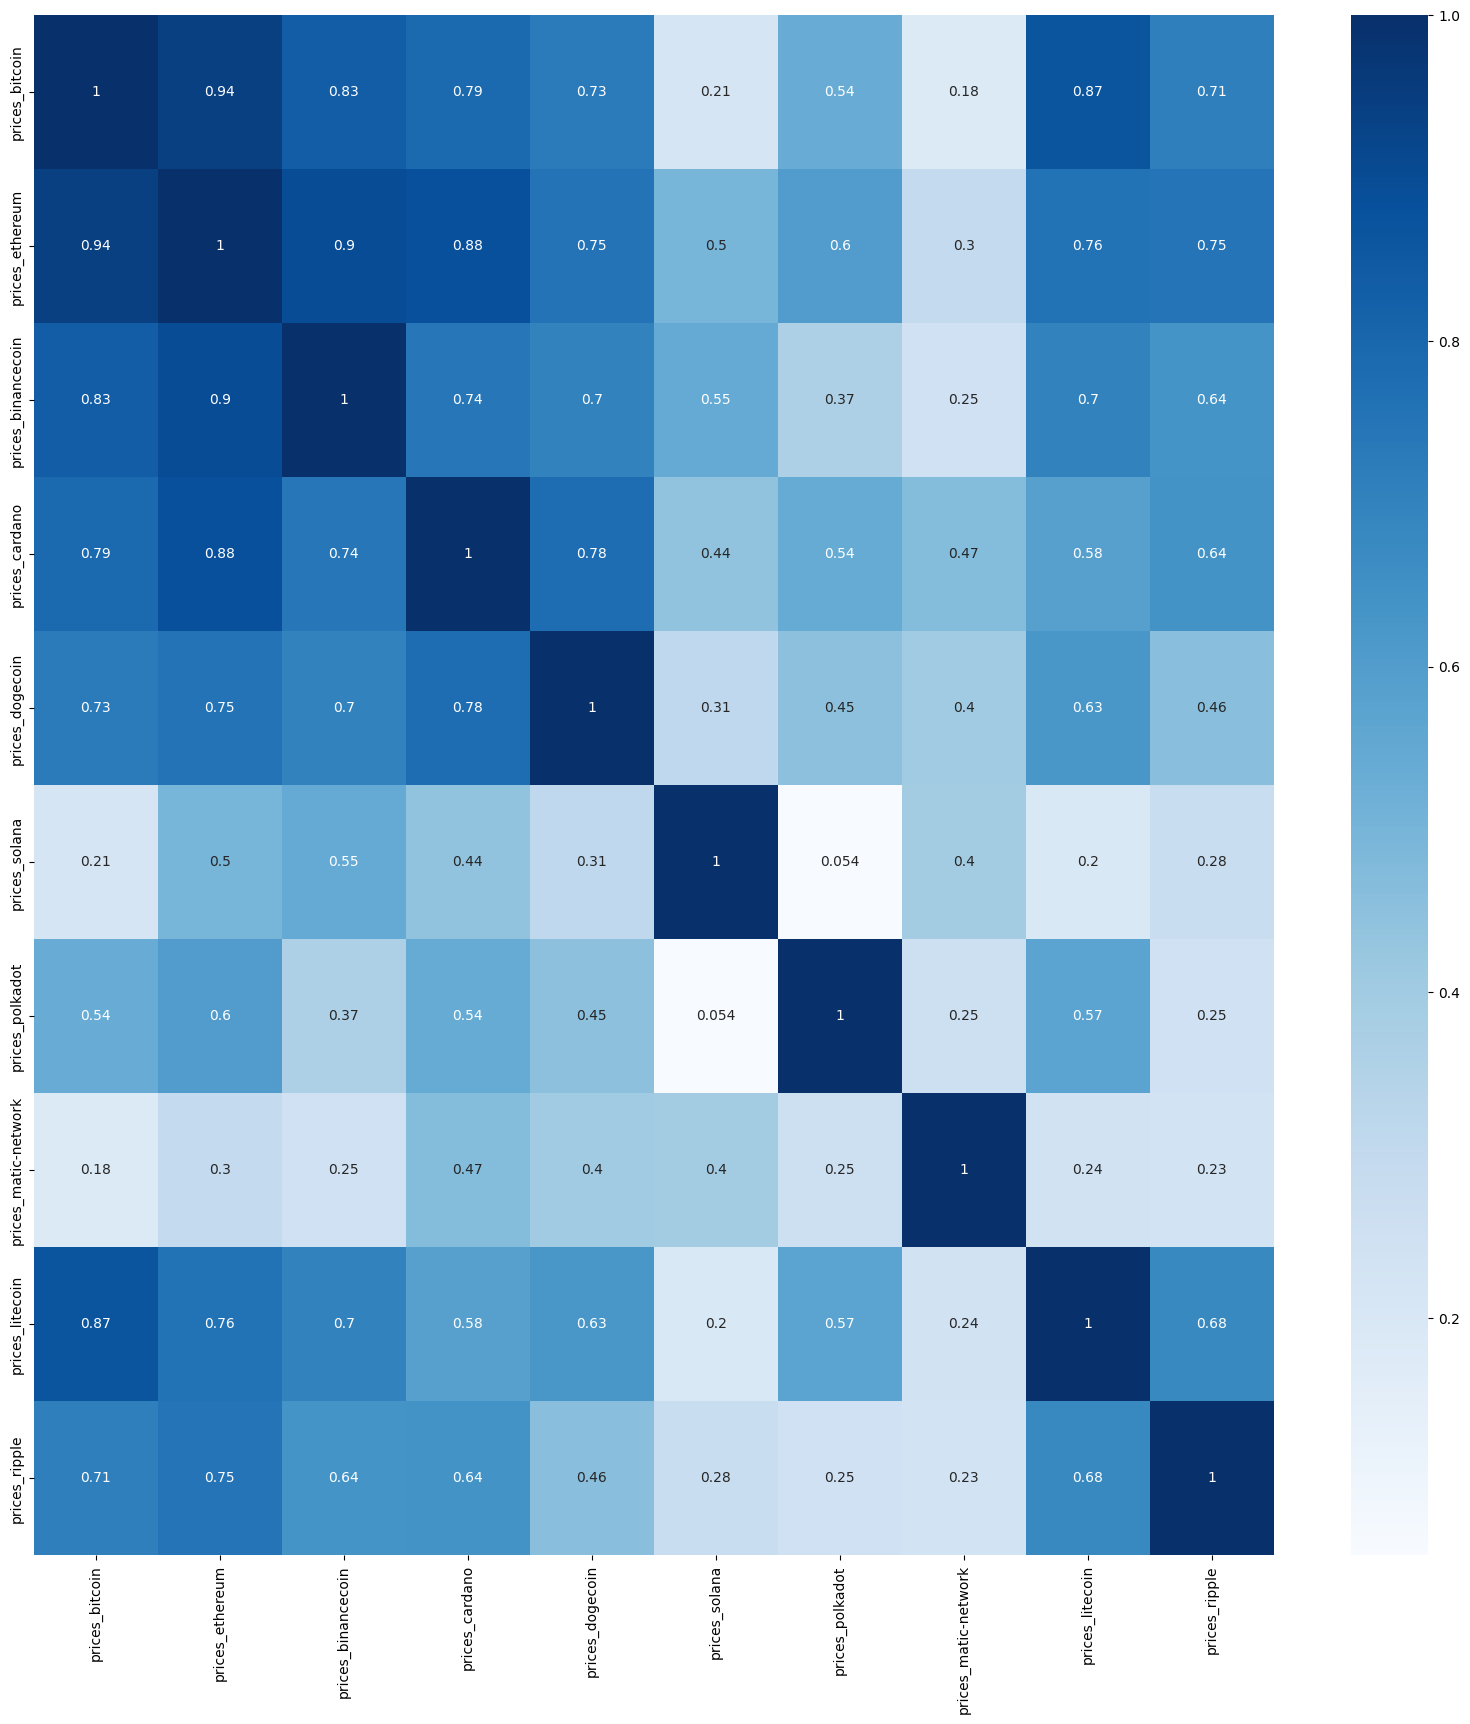

In [103]:
correlacion_precios_año2020 = (df_monedas_precios.iloc[:,2:][df_monedas_precios['fecha_año'] == 2020]).corr()
plt.figure(figsize=[20,20])
sns.heatmap(correlacion_precios_año2020, annot=True, cmap='Blues')

Se observa una muy alta asociación de `Bitcoin` con `Ethereum` (0.94) y `Litecoin` (0.87), y de `Ethereum` con `BNB` (0.9) y `Cardano` (0.88).

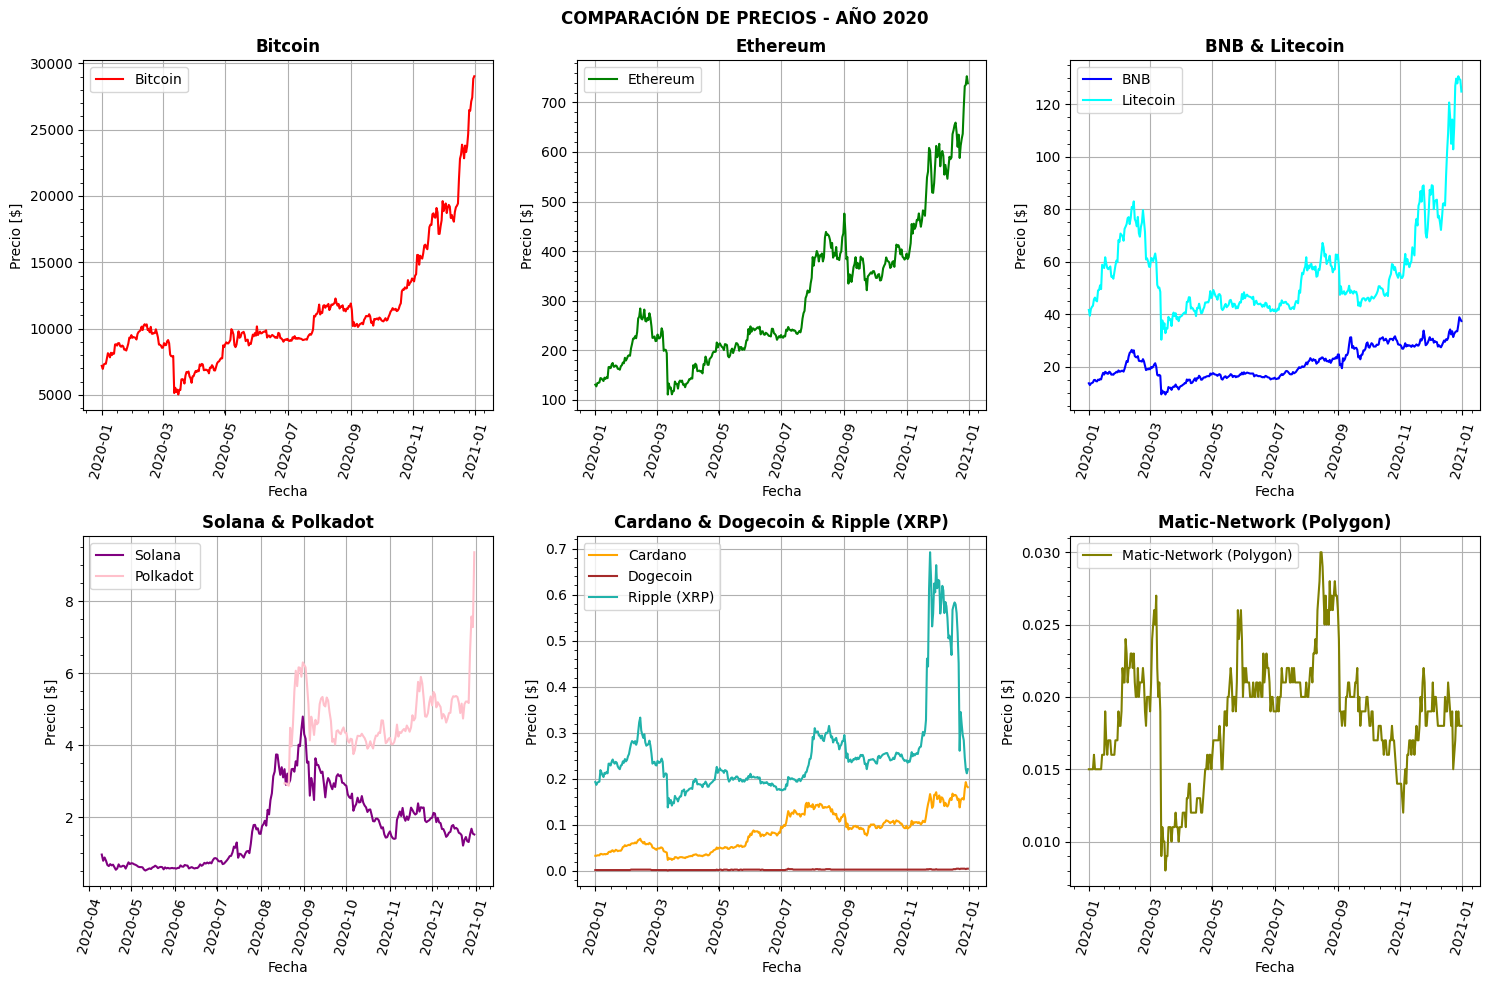

In [104]:
#Gráficas de precios para el año 2020

plt.figure(figsize=[15,10]) #tamaño de la gráfica
plt.suptitle('COMPARACIÓN DE PRECIOS - AÑO 2020').set_fontweight('extra bold') #título de la gráfica

### Bitcoin ###
plt.subplot(231)
plt.title('Bitcoin').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2020], 
        df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2020], 
        label='Bitcoin', color='red')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### Ethereum ###
plt.subplot(232)
plt.title('Ethereum').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2020], 
        df_monedas_precios['prices_ethereum'][df_monedas_precios['fecha_año'] == 2020], 
        label='Ethereum', color='green')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### BNB & Litecoin ###
plt.subplot(233)
plt.title('BNB & Litecoin').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2020], 
        df_monedas_precios['prices_binancecoin'][df_monedas_precios['fecha_año'] == 2020], 
        label='BNB', color='blue')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2020], 
        df_monedas_precios['prices_litecoin'][df_monedas_precios['fecha_año'] == 2020], 
        label='Litecoin', color='cyan')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### Solana & Polkadot ###
plt.subplot(234)
plt.title('Solana & Polkadot').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2020], 
        df_monedas_precios['prices_solana'][df_monedas_precios['fecha_año'] == 2020], 
        label='Solana', color='purple')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2020], 
        df_monedas_precios['prices_polkadot'][df_monedas_precios['fecha_año'] == 2020], 
        label='Polkadot', color='pink')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### Cardano & Dogecoin & Ripple (XRP) ###
plt.subplot(235)
plt.title('Cardano & Dogecoin & Ripple (XRP)').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2020], 
        df_monedas_precios['prices_cardano'][df_monedas_precios['fecha_año'] == 2020], 
        label='Cardano', color='orange')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2020], 
        df_monedas_precios['prices_dogecoin'][df_monedas_precios['fecha_año'] == 2020], 
        label='Dogecoin', color='brown')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2020], 
        df_monedas_precios['prices_ripple'][df_monedas_precios['fecha_año'] == 2020], 
        label='Ripple (XRP)', color='lightseagreen')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

### Matic-Network (Polygon) ###
plt.subplot(236)
plt.title('Matic-Network (Polygon)').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2020], 
        df_monedas_precios['prices_matic-network'][df_monedas_precios['fecha_año'] == 2020], 
        label='Matic-Network (Polygon)', color='olive')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.tight_layout()

Se aprecia que todas las monedas aumentaron su precio si se compara el inicio del año con el final. Además, todas a excepción de `Solana`, `XRP` y `Polygon` mantuvieron su tendencia alcista durante casi todo el año, en especial en el segundo semestre.

<mark>Para el año 2021:

In [105]:
df_monedas_precios[df_monedas_precios['fecha_año'] == 2021].describe()

,fecha_año,prices_bitcoin,prices_ethereum,prices_binancecoin,prices_cardano,prices_dogecoin,prices_solana,prices_polkadot,prices_matic-network,prices_litecoin,prices_ripple
count,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2021.0,47489.120871,2783.207737,378.756540,1.500841,0.205151,80.185200,29.094378,1.076455,186.026400,0.868323
std,0.0,9804.052156,1028.069223,169.375081,0.616015,0.126815,77.183771,10.484846,0.704689,48.264781,0.348818
min,2021.0,29352.127000,730.147000,37.907000,0.176000,0.006000,1.803000,8.263000,0.018000,107.824000,0.222000
25%,2021.0,38321.455000,1900.122000,288.172000,1.190000,0.064000,19.738000,20.762000,0.368000,152.068000,0.576000
50%,2021.0,47885.872000,2632.657000,378.304000,1.395000,0.219000,39.042000,29.240000,1.127000,178.552000,0.896000
75%,2021.0,56335.035000,3659.922000,516.787000,1.992000,0.272000,157.378000,36.726000,1.589000,202.579000,1.098000
max,2021.0,67617.016000,4815.005000,675.099000,2.967000,0.682000,259.240000,54.143000,2.882000,384.672000,1.838000


Se vuelve a observar una gran diferencia entre el valor mínimo y máximo en todas las monedas.

<Axes: >

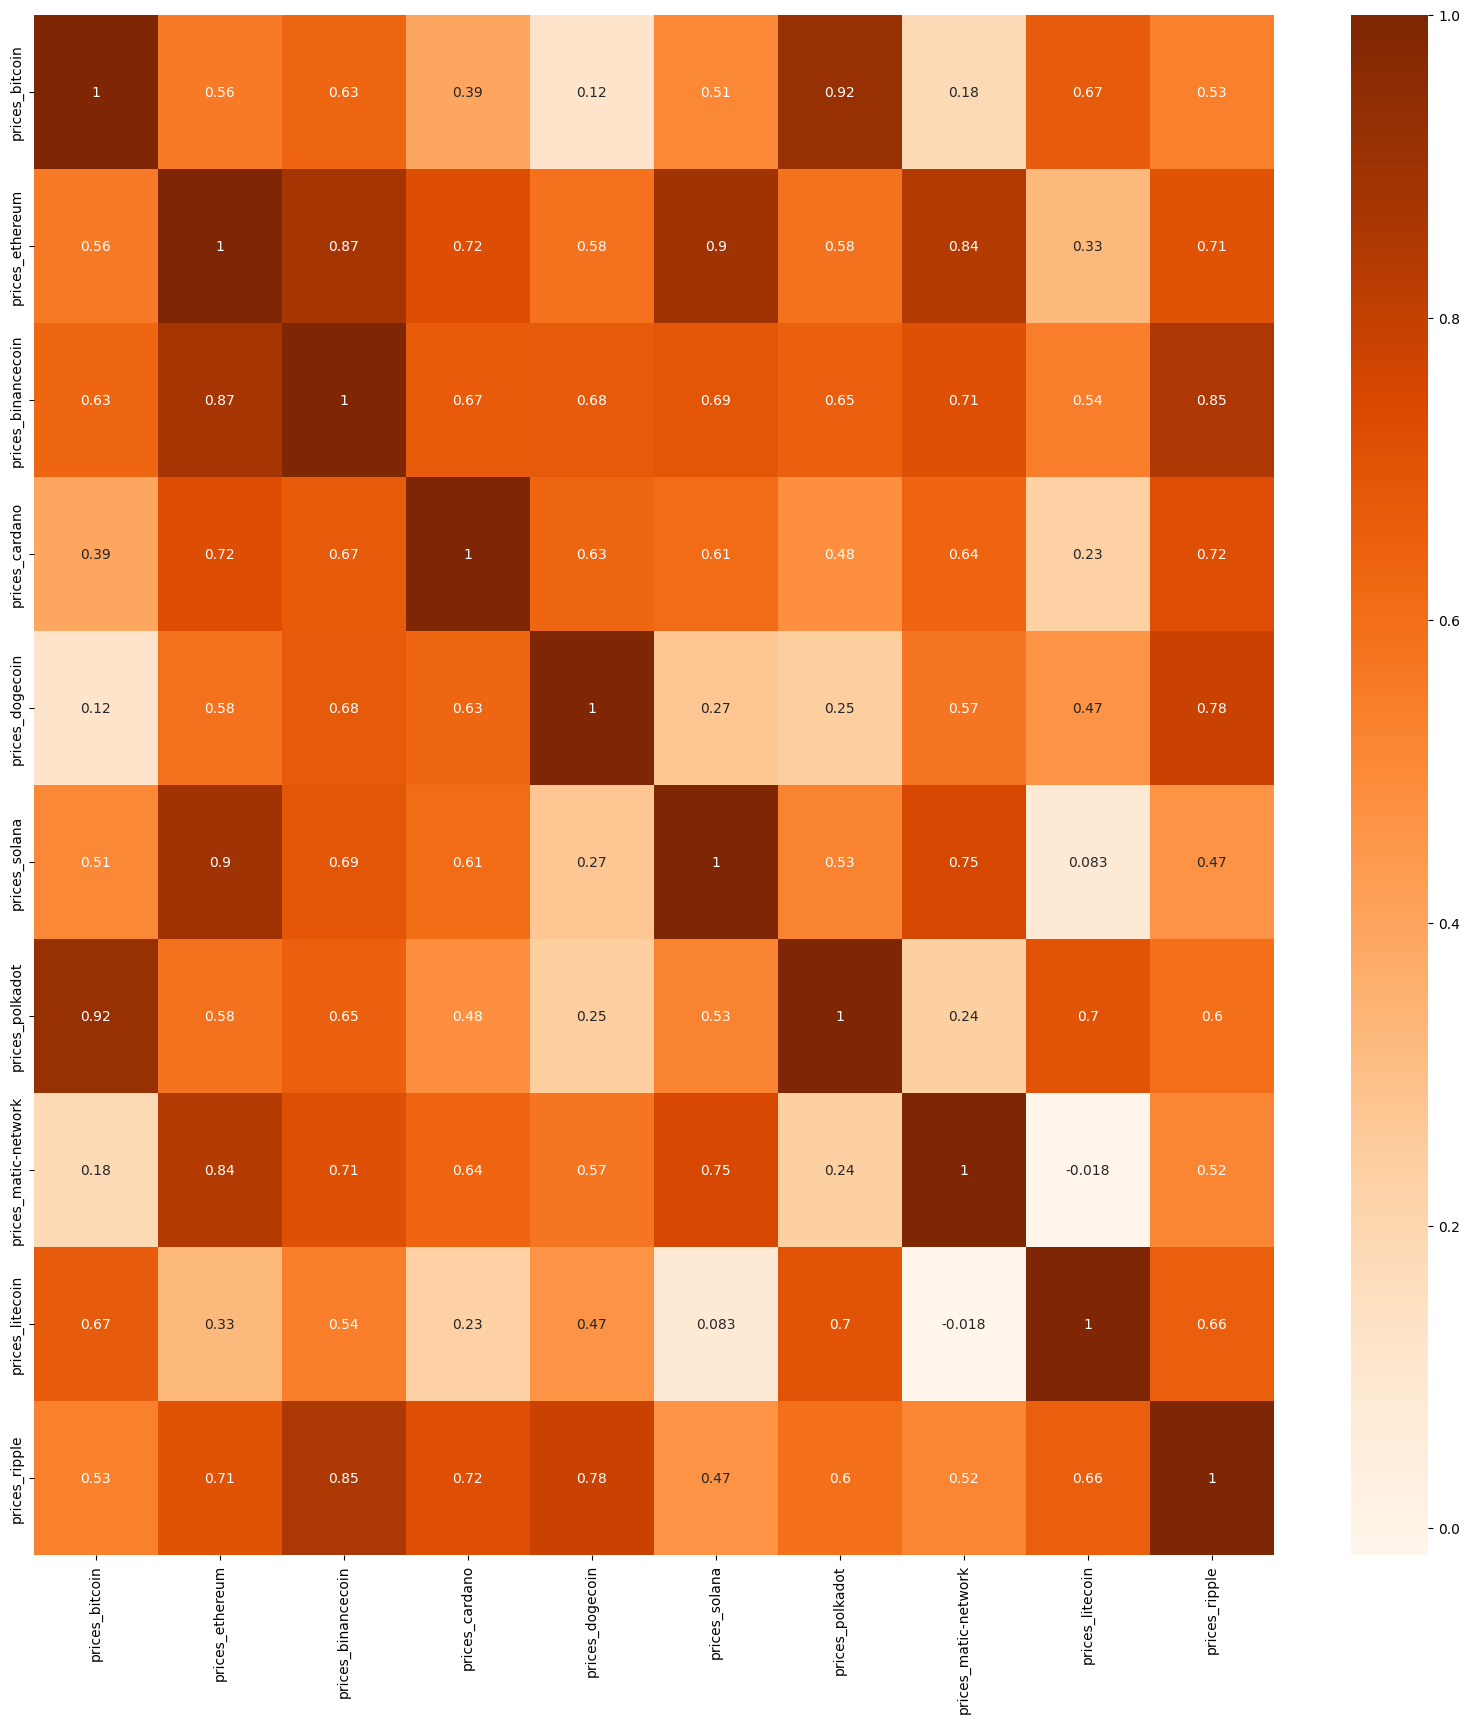

In [106]:
correlacion_precios_año2021 = (df_monedas_precios.iloc[:,2:][df_monedas_precios['fecha_año'] == 2021]).corr()
plt.figure(figsize=[20,20])
sns.heatmap(correlacion_precios_año2021, annot=True, cmap='Oranges')

Se observa una muy alta asociación de `Bitcoin` con `Polkadot` (0.92), y de `Ethereum` con `Solana` (0.9), `BNB` (0.87) y `Polygon` (0.84).

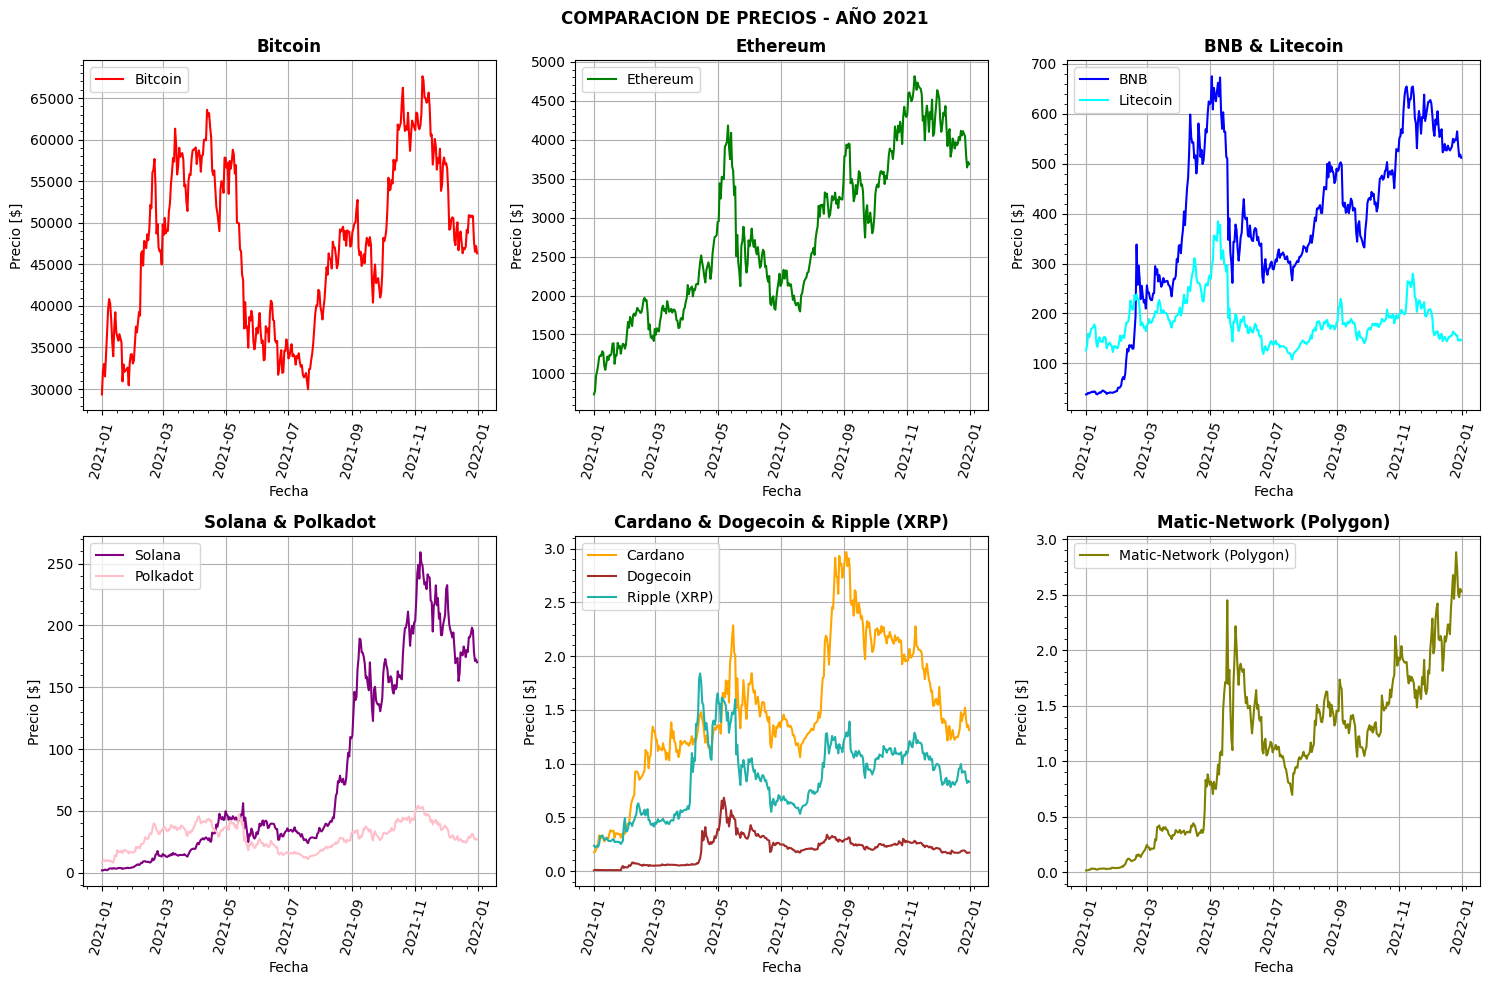

In [107]:
#Gráficas de precios para el año 2021

plt.figure(figsize=[15,10])
plt.suptitle('COMPARACION DE PRECIOS - AÑO 2021').set_fontweight('extra bold')

plt.subplot(231)
plt.title('Bitcoin').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2021], 
        df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2021], 
        label='Bitcoin', color='red')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(232)
plt.title('Ethereum').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2021], 
        df_monedas_precios['prices_ethereum'][df_monedas_precios['fecha_año'] == 2021], 
        label='Ethereum', color='green')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(233)
plt.title('BNB & Litecoin').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2021], 
        df_monedas_precios['prices_binancecoin'][df_monedas_precios['fecha_año'] == 2021], 
        label='BNB', color='blue')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2021], 
        df_monedas_precios['prices_litecoin'][df_monedas_precios['fecha_año'] == 2021], 
        label='Litecoin', color='cyan')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(234)
plt.title('Solana & Polkadot').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2021], 
        df_monedas_precios['prices_solana'][df_monedas_precios['fecha_año'] == 2021], 
        label='Solana', color='purple')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2021], 
        df_monedas_precios['prices_polkadot'][df_monedas_precios['fecha_año'] == 2021], 
        label='Polkadot', color='pink')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(235)
plt.title('Cardano & Dogecoin & Ripple (XRP)').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2021], 
        df_monedas_precios['prices_cardano'][df_monedas_precios['fecha_año'] == 2021], 
        label='Cardano', color='orange')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2021], 
        df_monedas_precios['prices_dogecoin'][df_monedas_precios['fecha_año'] == 2021], 
        label='Dogecoin', color='brown')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2021], 
        df_monedas_precios['prices_ripple'][df_monedas_precios['fecha_año'] == 2021], 
        label='Ripple (XRP)', color='lightseagreen')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(236)
plt.title('Matic-Network (Polygon)').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2021], 
        df_monedas_precios['prices_matic-network'][df_monedas_precios['fecha_año'] == 2021], 
        label='Matic-Network (Polygon)', color='olive')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.tight_layout()

Se aprecia que todas las monedas aumentaron su precio si se compara el inicio del año con el final. Además, se observa que `Ethereum`, `BNB`, `Solana` y `Polygon` mantuvieron su tendencia alcista durante casi todo el año, en especial antes y después de mitad de año.

<mark>Para el año 2022:

In [108]:
df_monedas_precios[df_monedas_precios['fecha_año'] == 2022].describe()

,fecha_año,prices_bitcoin,prices_ethereum,prices_binancecoin,prices_cardano,prices_dogecoin,prices_solana,prices_polkadot,prices_matic-network,prices_litecoin,prices_ripple
count,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2022.0,28215.214452,1989.061381,324.564452,0.643055,0.098074,57.957408,11.562071,1.075551,80.089216,0.513734
std,0.0,10210.656346,776.086191,71.664881,0.308633,0.035091,39.191580,6.559397,0.464734,29.079050,0.180912
min,2022.0,15742.444000,995.253000,197.377000,0.244000,0.053000,9.598000,4.281000,0.347000,43.292000,0.309000
25%,2022.0,19557.896000,1294.271000,272.360000,0.431000,0.067000,31.819000,6.451000,0.779000,56.134000,0.366000
50%,2022.0,23197.603000,1682.011000,299.463000,0.507000,0.085000,40.126000,8.104000,0.896000,66.148000,0.423000
75%,2022.0,39090.202000,2768.972000,385.652000,0.896000,0.133000,91.606000,17.954000,1.436000,107.022000,0.707000
max,2022.0,47816.078000,3835.396000,531.646000,1.589000,0.185000,178.889000,30.152000,2.582000,151.762000,0.881000


<Axes: >

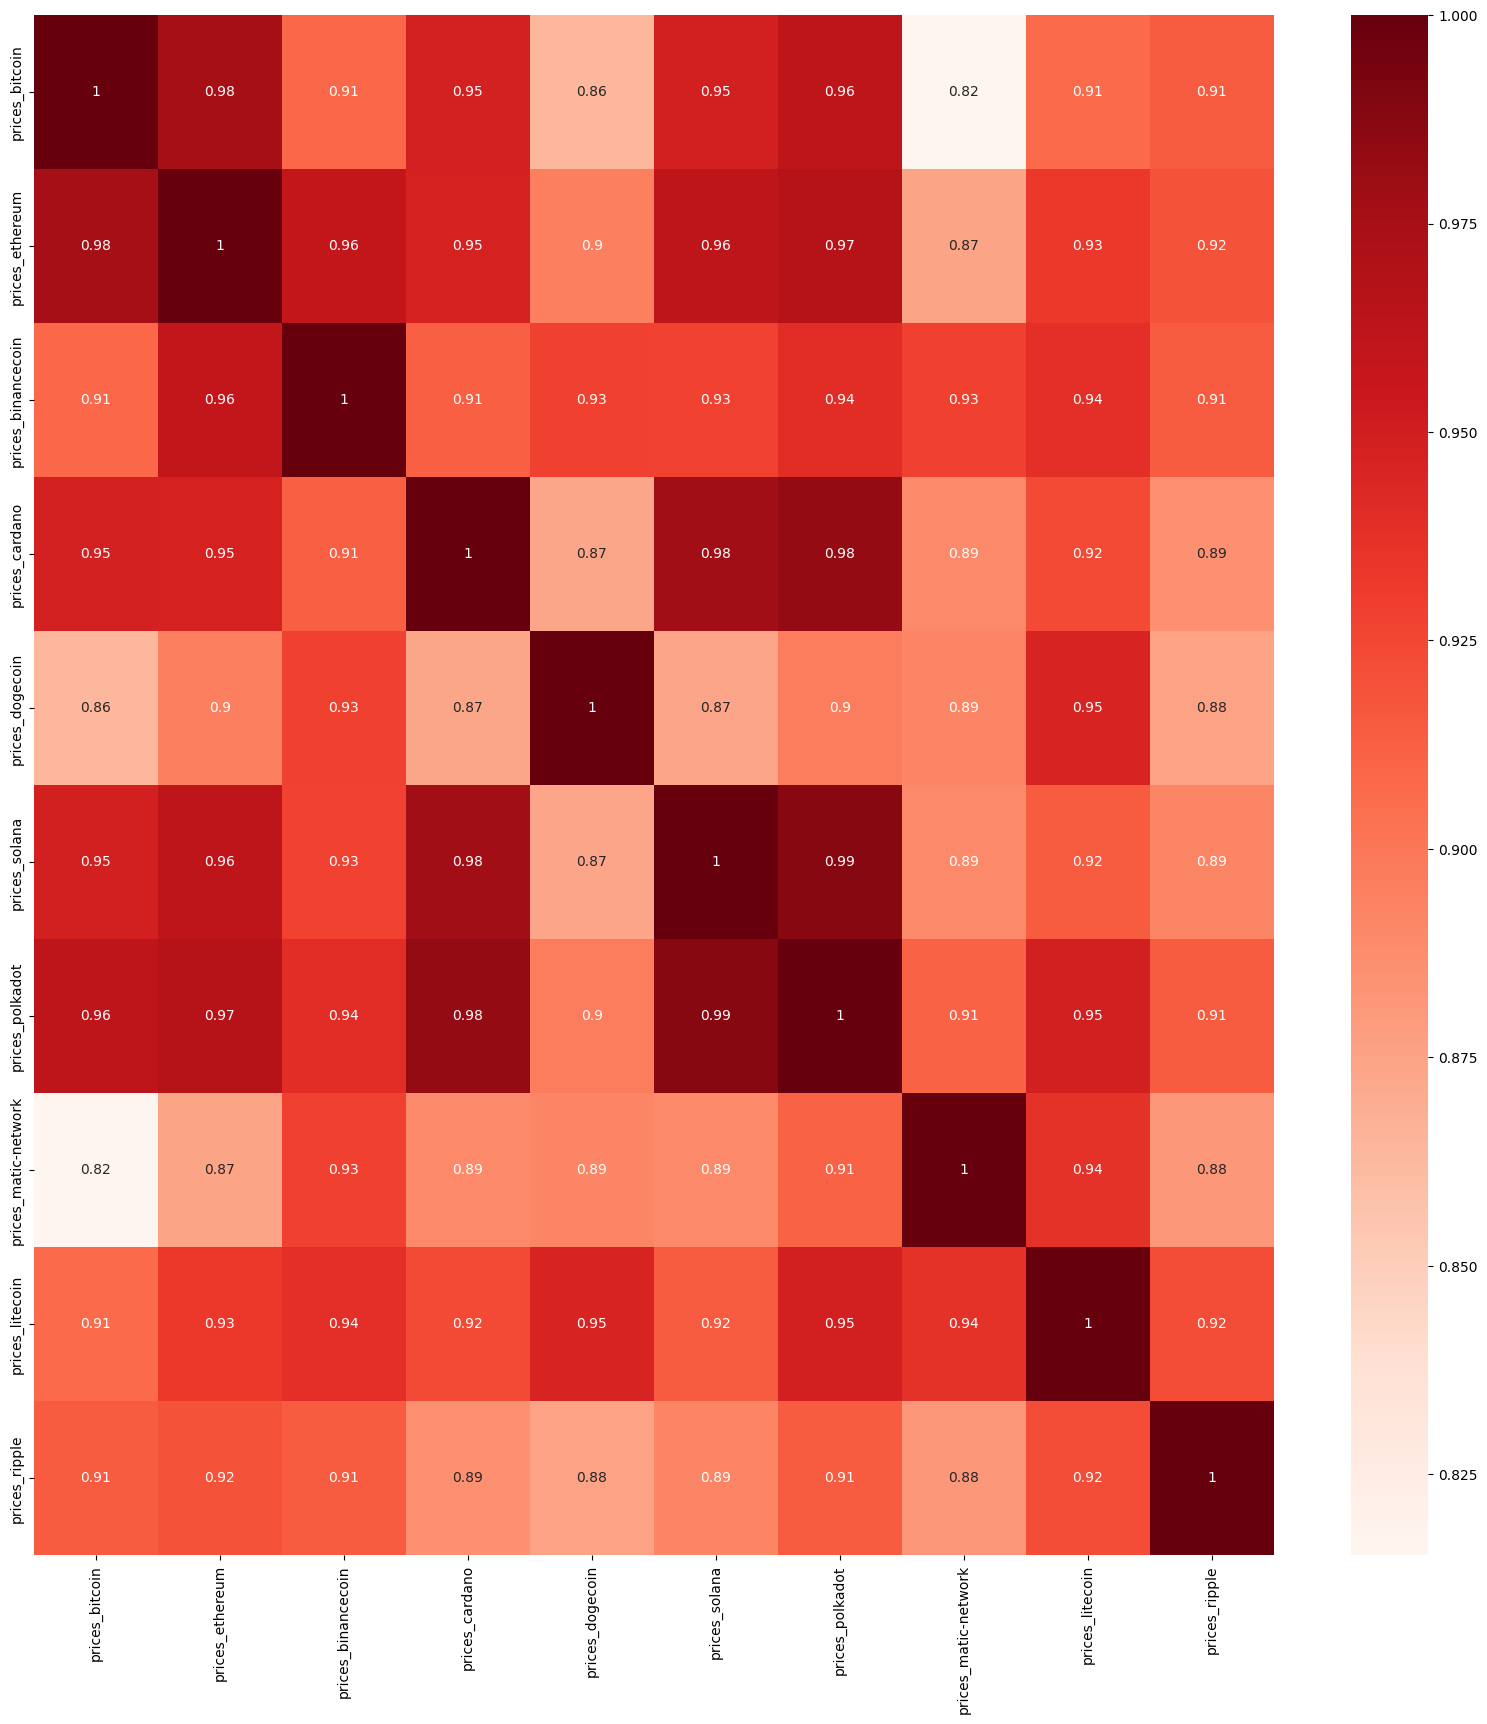

In [109]:
correlacion_precios_año2022 = (df_monedas_precios.iloc[:,2:][df_monedas_precios['fecha_año'] == 2022]).corr()
plt.figure(figsize=[20,20])
sns.heatmap(correlacion_precios_año2022, annot=True, cmap='Reds')

Se observa una muy alta asociación de todas las criptomonedas.

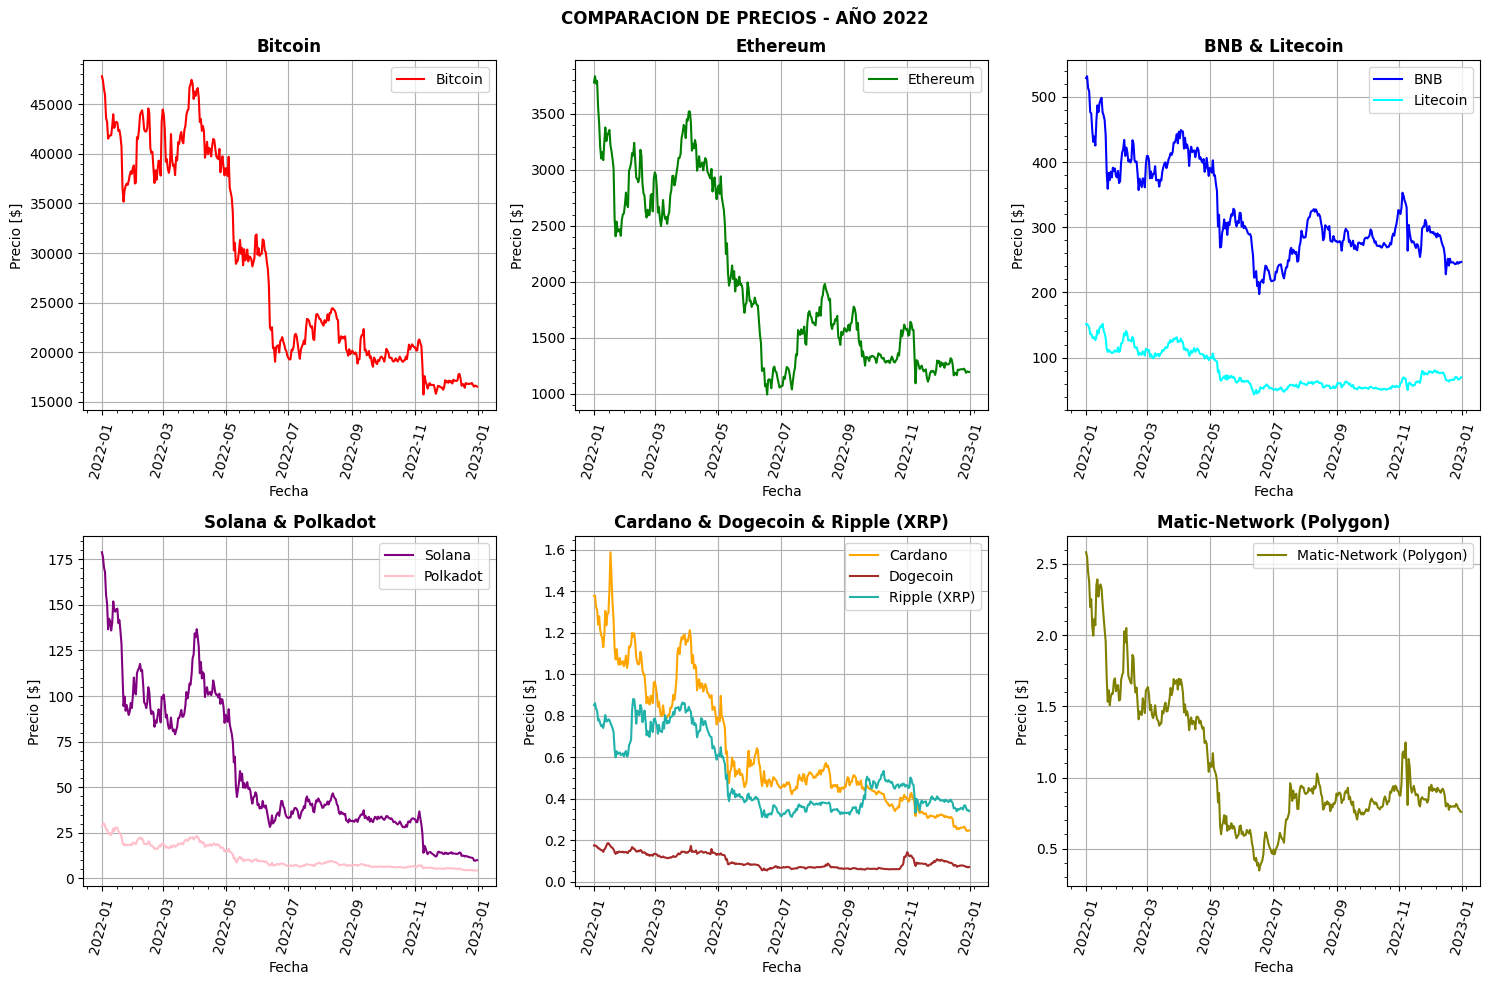

In [110]:
#Gráficas de precios para el año 2022

plt.figure(figsize=[15,10])
plt.suptitle('COMPARACION DE PRECIOS - AÑO 2022').set_fontweight('extra bold')

plt.subplot(231)
plt.title('Bitcoin').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2022], 
        df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2022], 
        label='Bitcoin', color='red')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(232)
plt.title('Ethereum').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2022], 
        df_monedas_precios['prices_ethereum'][df_monedas_precios['fecha_año'] == 2022], 
        label='Ethereum', color='green')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(233)
plt.title('BNB & Litecoin').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2022], 
        df_monedas_precios['prices_binancecoin'][df_monedas_precios['fecha_año'] == 2022], 
        label='BNB', color='blue')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2022], 
        df_monedas_precios['prices_litecoin'][df_monedas_precios['fecha_año'] == 2022], 
        label='Litecoin', color='cyan')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(234)
plt.title('Solana & Polkadot').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2022], 
        df_monedas_precios['prices_solana'][df_monedas_precios['fecha_año'] == 2022], 
        label='Solana', color='purple')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2022], 
        df_monedas_precios['prices_polkadot'][df_monedas_precios['fecha_año'] == 2022], 
        label='Polkadot', color='pink')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(235)
plt.title('Cardano & Dogecoin & Ripple (XRP)').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2022], 
        df_monedas_precios['prices_cardano'][df_monedas_precios['fecha_año'] == 2022], 
        label='Cardano', color='orange')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2022], 
        df_monedas_precios['prices_dogecoin'][df_monedas_precios['fecha_año'] == 2022], 
        label='Dogecoin', color='brown')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2022], 
        df_monedas_precios['prices_ripple'][df_monedas_precios['fecha_año'] == 2022], 
        label='Ripple (XRP)', color='lightseagreen')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(236)
plt.title('Matic-Network (Polygon)').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2022], 
        df_monedas_precios['prices_matic-network'][df_monedas_precios['fecha_año'] == 2022], 
        label='Matic-Network (Polygon)', color='olive')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.tight_layout()

Se aprecia que todas las monedas disminuyeron su precio si se compara el inicio del año con el final. Además, la tendencia fue bajista en todas las monedas durante todo el año.

Lo anterior se corrobora con lo siguientes artículos que informaron en su momento que el 2022 fue un pésimo año para las criptomonedas ('cripto invierno') y además, fue el peor en 14 años de funcionamiento del Bitcoin. Esto se debió a muchos factores, entre ellos: derrumbe de la criptomoneda Terra/Luna, la bancarrota de FTX, al manejo inescrupuloso de grandes inversionistas que manejaban recursos de miles de personas que habían entrado en esa actividad, altas tasas de interés, entre otras.

https://forbes.es/criptomonedas/214792/por-que-2022-fue-un-pesimo-ano-para-las-criptomonedas/#:~:text=La%20ca%C3%ADda%20total%20en%20la,las%20criptomonedas%20cay%C3%B3%20en%202022.
https://www.portafolio.co/economia/finanzas/bitcoin-2022-fue-el-peor-en-14-anos-de-funcionamiento-del-activo-digital-576911

<mark>Para el año 2023:

In [111]:
df_monedas_precios[df_monedas_precios['fecha_año'] == 2023].describe()

,fecha_año,prices_bitcoin,prices_ethereum,prices_binancecoin,prices_cardano,prices_dogecoin,prices_solana,prices_polkadot,prices_matic-network,prices_litecoin,prices_ripple
count,230.0,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000
mean,2023.0,26367.516896,1755.668178,287.628083,0.344387,0.076357,21.244117,5.672343,0.941848,88.850248,0.481335
std,0.0,3597.730815,173.628052,35.706838,0.046970,0.008295,3.144094,0.705349,0.222382,7.702565,0.106139
min,2023.0,16615.969000,1200.659000,215.973000,0.250000,0.060000,9.974000,4.369000,0.572000,64.077000,0.338000
25%,2023.0,23540.036750,1649.179250,244.331750,0.299500,0.071000,20.092500,5.153750,0.730000,83.985000,0.396000
50%,2023.0,27295.753500,1818.685500,304.788000,0.356000,0.075000,21.397500,5.489500,0.937000,89.707000,0.468000
75%,2023.0,29266.601000,1872.068500,314.141250,0.383000,0.082000,23.498250,6.233000,1.118500,93.721250,0.516250
max,2023.0,31446.015000,2118.599000,347.866000,0.454000,0.096000,27.365000,7.527000,1.531000,113.166000,0.821000


<Axes: >

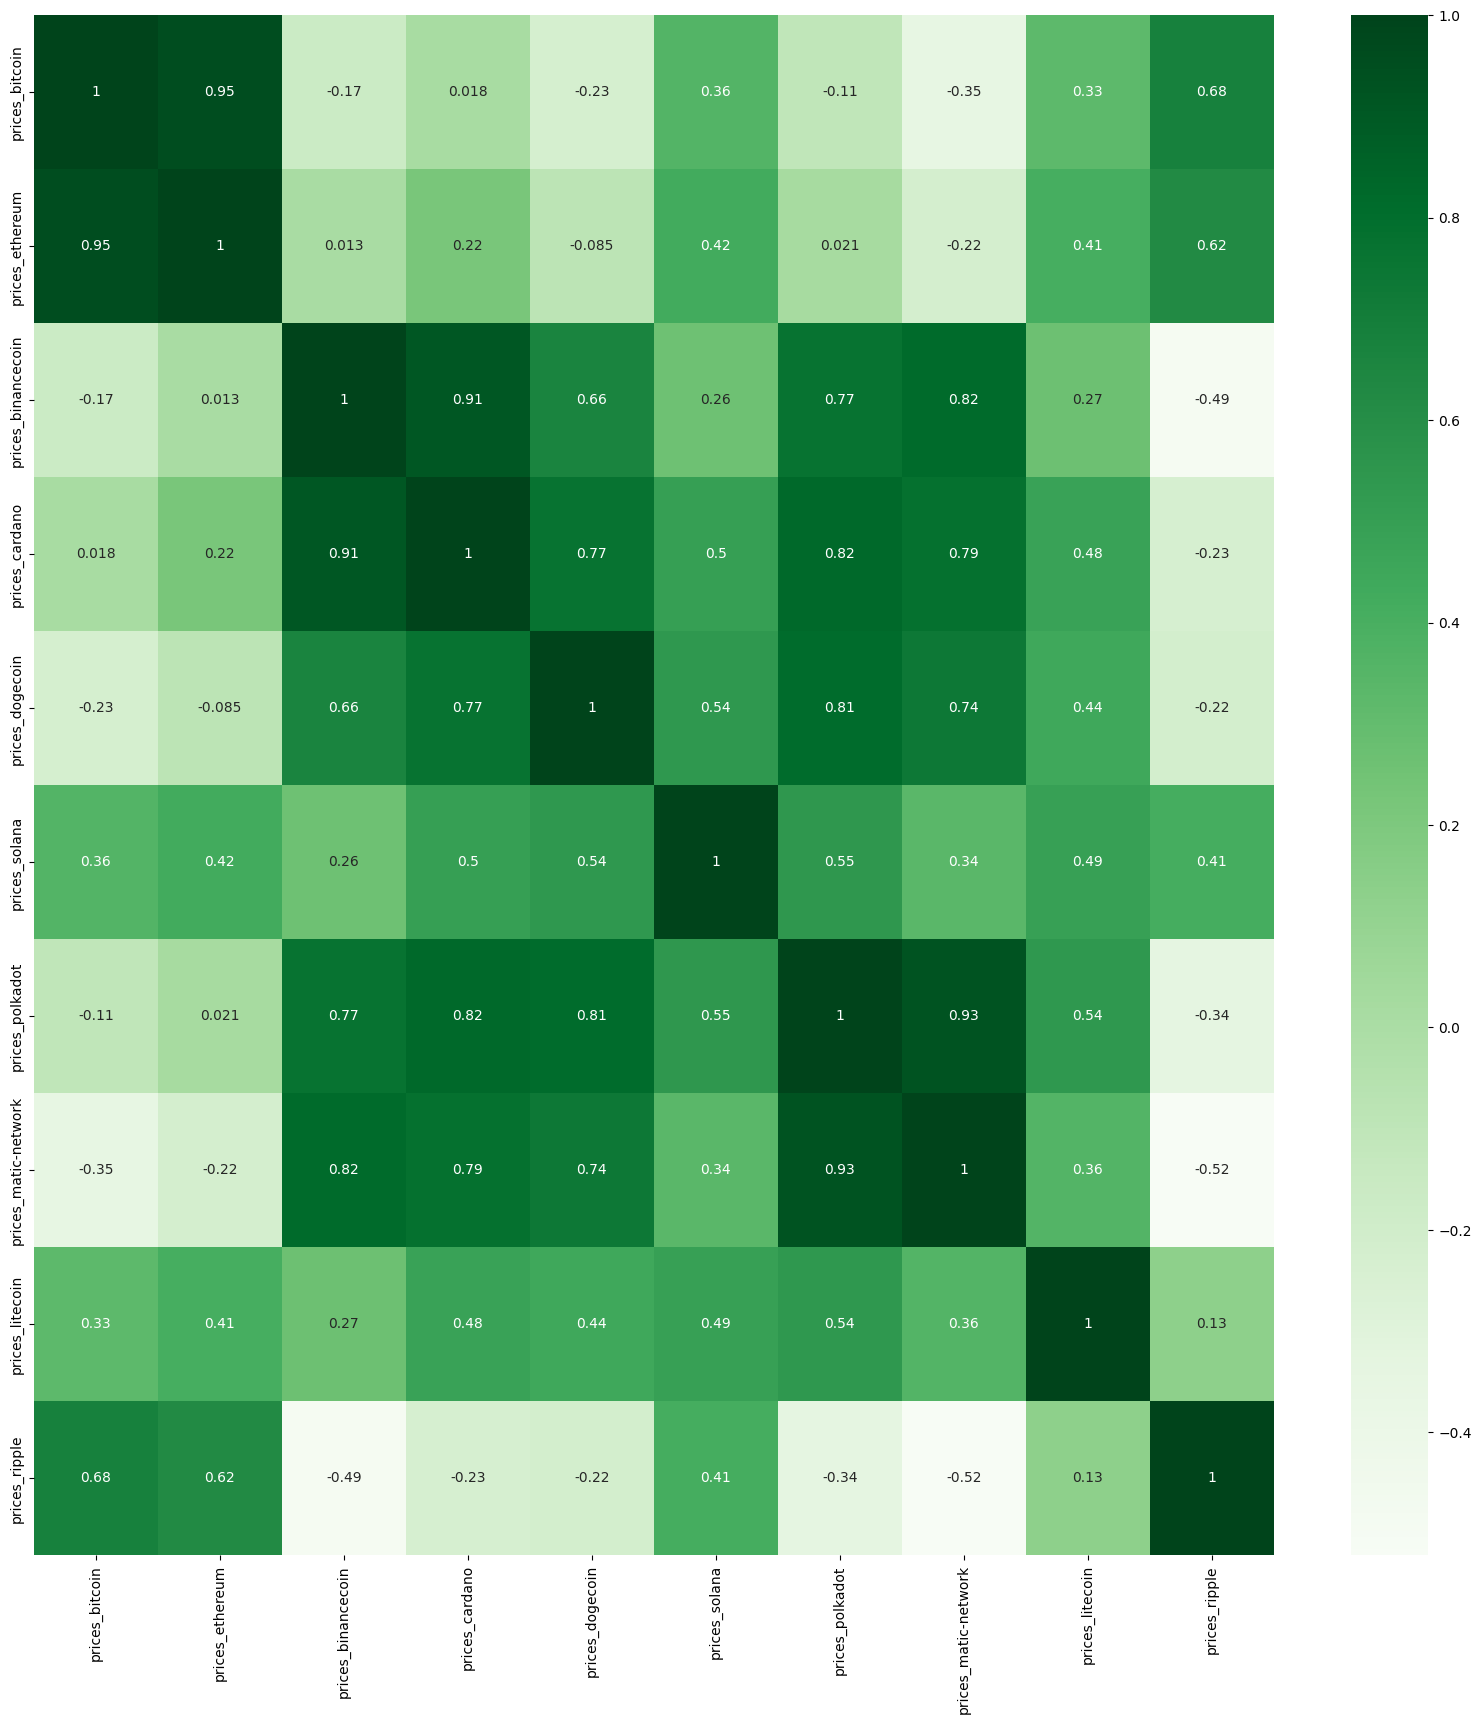

In [112]:
correlacion_precios_año2023 = (df_monedas_precios.iloc[:,2:][df_monedas_precios['fecha_año'] == 2023]).corr()
plt.figure(figsize=[20,20])
sns.heatmap(correlacion_precios_año2023, annot=True, cmap='Greens')

En lo que va transcurrido del año, existe una muy alta asociación del `Bitcoin` con el `Ethereum` (de 0.95), de `Polygon` con `Polkadot` (de 0.93) y del `BNB` con el `Cardano` (de 0.91).

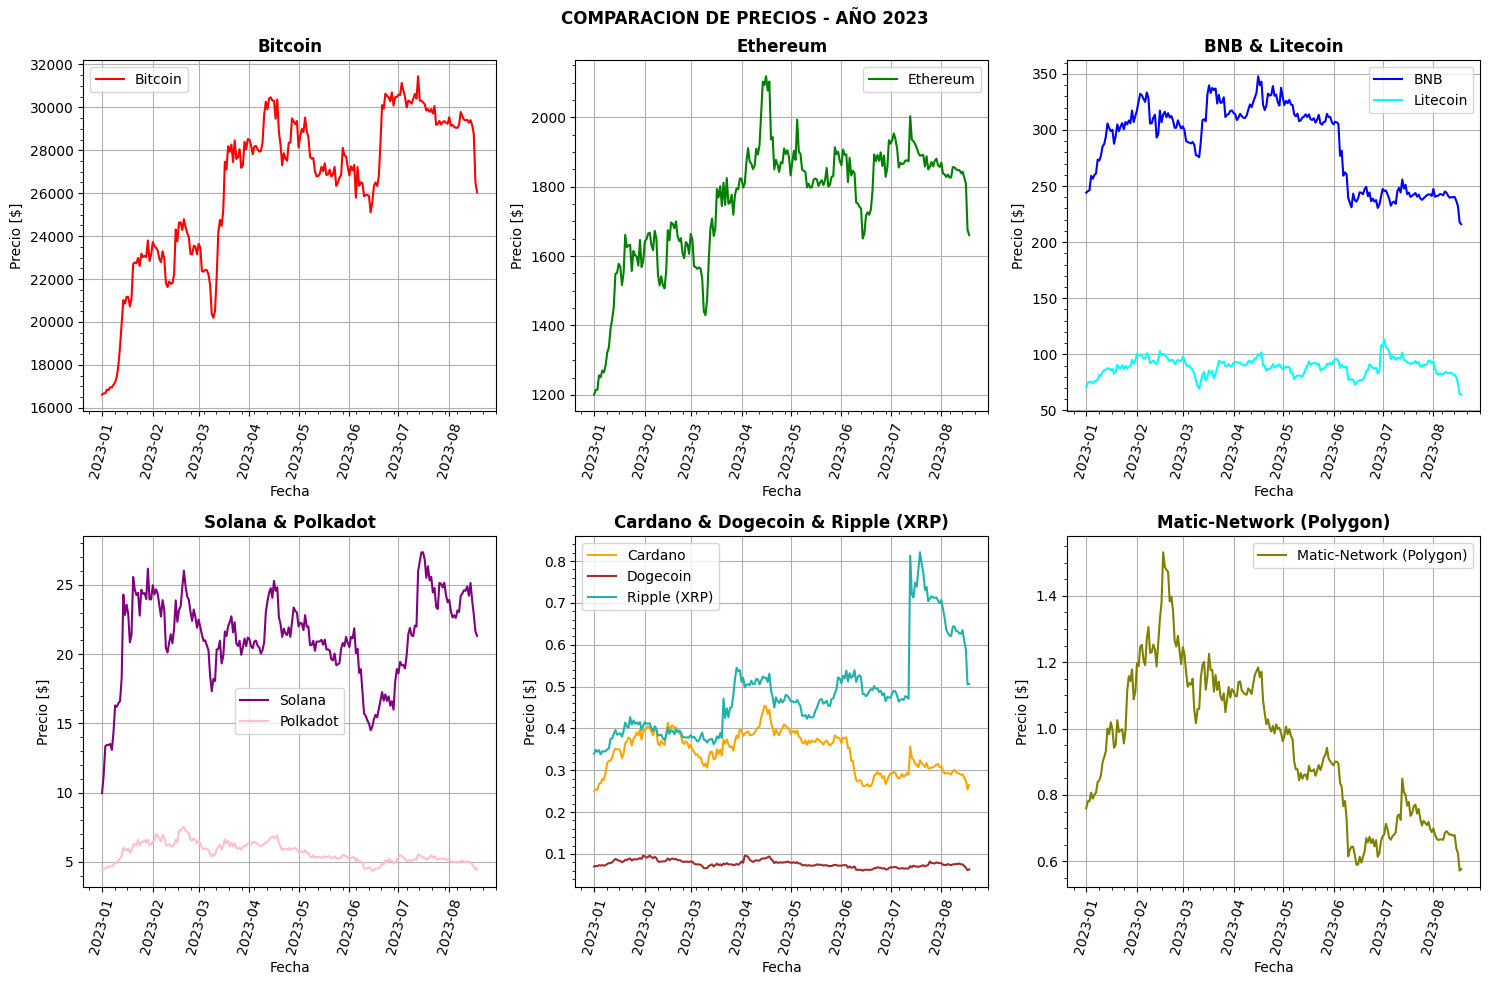

In [113]:
#Gráficas de precios para el año 2023

plt.figure(figsize=[15,10])
plt.suptitle('COMPARACION DE PRECIOS - AÑO 2023').set_fontweight('extra bold')

plt.subplot(231)
plt.title('Bitcoin').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2023], 
        df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2023], 
        label='Bitcoin', color='red')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(232)
plt.title('Ethereum').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2023], 
        df_monedas_precios['prices_ethereum'][df_monedas_precios['fecha_año'] == 2023], 
        label='Ethereum', color='green')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(233)
plt.title('BNB & Litecoin').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2023], 
        df_monedas_precios['prices_binancecoin'][df_monedas_precios['fecha_año'] == 2023], 
        label='BNB', color='blue')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2023], 
        df_monedas_precios['prices_litecoin'][df_monedas_precios['fecha_año'] == 2023], 
        label='Litecoin', color='cyan')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(234)
plt.title('Solana & Polkadot').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2023], 
        df_monedas_precios['prices_solana'][df_monedas_precios['fecha_año'] == 2023], 
        label='Solana', color='purple')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2023], 
        df_monedas_precios['prices_polkadot'][df_monedas_precios['fecha_año'] == 2023], 
        label='Polkadot', color='pink')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(235)
plt.title('Cardano & Dogecoin & Ripple (XRP)').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2023], 
        df_monedas_precios['prices_cardano'][df_monedas_precios['fecha_año'] == 2023], 
        label='Cardano', color='orange')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2023], 
        df_monedas_precios['prices_dogecoin'][df_monedas_precios['fecha_año'] == 2023], 
        label='Dogecoin', color='brown')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2023], 
        df_monedas_precios['prices_ripple'][df_monedas_precios['fecha_año'] == 2023], 
        label='Ripple (XRP)', color='lightseagreen')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.subplot(236)
plt.title('Matic-Network (Polygon)').set_fontweight('bold')
plt.plot(df_monedas_precios['fecha'][df_monedas_precios['fecha_año'] == 2023], 
        df_monedas_precios['prices_matic-network'][df_monedas_precios['fecha_año'] == 2023], 
        label='Matic-Network (Polygon)', color='olive')
plt.xticks(rotation=75)
plt.xlabel('Fecha')
plt.ylabel('Precio [$]')
plt.grid()
plt.minorticks_on()
plt.legend()

plt.tight_layout()

Se observa una tendencia alcista muy notable del `Bitcoin` y `Ethereum`, en especial cada 3 meses (marzo y junio) luego de bajar un poco el precio (efecto rebote); su precio ha aumentado si se le compara con el de inicio de año. Por otra parte, el `BNB` y `Polygon` tienen tendencia bajista luego del primer y segundo trimestre, respectivamente; su precio ha disminuido si se le compara con el de inicio de año. `Ripple` (`XRP`) ha tenido una ligera tendecia alcista en el año. Las demás criptomendas han estado más estables o con tendecia lateral.

## **Conclusiones**

<ol>

<hr/>
<li>Todas las criptomonedas tienen una alta volatilidad en cuanto al precio pues su desviación estándar es alta con respecto a la media; en algunas monedas estas 2 métricas suelen tener valores muy cercanos, inclusive se encontraron desviaciones estándar mayores que la media.</li><hr/>

<li>Todas las criptomonedas han aumentado de precio si se le compara el que tenían a inicios del año 2020 con el precio actual, desde luego, unas en mayor proporción que otras.</li><hr/>

<li>Los precios máximos de todas las criptomonedas se dieron en el año 2021. Se destaca el hecho de que la fecha del `Bitcoin` y Ethereum` fue la misma (08 de noviembre).</li><hr/>

<li>Las asociaciones o correlaciones lineales más altas de precios se dan entre `Ethereum` y `BNB` (de 0.94), y `Bitcoin` con `Polkadot` (de 0.93). Además, existe una asociación muy alta de todas las criptomonedas con `Ethereum` y `Bitcoin`. Con el primero de ellos especialmente el `BNB` (0.94) y el mismo `Bitcoin` (0.89), y con el segundo, el `Polkadot` (0.93), `Ethereum` y `Litecoin` (0.89).</li><hr/>

<li>En el año 2020 y 2021, todas las monedas aumentaron su precio si se compara el inicio del año con el final. Caso contrario ocurrió en el 2022, donde el precio de todas disminuyó. Y en lo que va de transcurrido este año, no todas las monedas han mantenido el mismo comportamiento, pues se observó una tendencia alcista muy notable del `Bitcoin` y `Ethereum`, en especial cada 3 meses (marzo y junio) luego de bajar un poco su precio (efecto rebote), el `BNB` y `Polygon` tienen tendencia bajista, `Ripple` (`XRP`) ha tenido una ligera tendecia alcista y las demás criptomendas han estado más estables o con tendecia lateral.</li><hr/>

<li> En cuanto a los volúmenes de transacciones, se observó que existen diferentes tipos de correlaciones: positivas altas, nulas y negativas. Las positivas altas fueron entre `Polkadot` y `Cardano`, y el `Bitcoin` con el `Ethereum`. En cuanto a las asociaciónes casi nulas, todas se dieron con la criptomoneda `Solana`, incluyendo la relación negativa con `Litecoin`. Por otra parte, los volúmenes máximos de todas las monedas se dieron en el año 2021.</li><hr/>

</ol>

## **KPI'S**

A continuación, se sugieren 3 KPIs relacionados con el análisis realizado anteriormente.

Como se analizó que existe una asociación muy alta de todas las criptomonedas con el `Bitcoin` entonces los KPIs están planteados para él. Por lo tanto, se usa el mismo dataframe del estudio de precios pero anexándole una nueva columna llamada 'fecha_mes' que es la extracción del mes de la columna 'fecha' con el fin de usar este como filtro de los KPIs.

In [114]:
df_monedas_precios.insert(loc=2, column='fecha_mes', value= df_monedas_precios.loc[:,'fecha'].apply(lambda x: x.month))
df_monedas_precios

,fecha,fecha_año,fecha_mes,prices_bitcoin,prices_ethereum,prices_binancecoin,prices_cardano,prices_dogecoin,prices_solana,prices_polkadot,prices_matic-network,prices_litecoin,prices_ripple
0,2020-01-01,2020,1,7193.755,130.485,13.686,0.033,0.002,NaN,NaN,0.015,41.606,0.193
1,2020-01-02,2020,1,6963.853,127.045,13.007,0.033,0.002,NaN,NaN,0.015,39.414,0.187
2,2020-01-03,2020,1,7300.347,133.703,13.603,0.034,0.002,NaN,NaN,0.015,41.991,0.192
3,2020-01-04,2020,1,7351.377,134.137,13.795,0.034,0.002,NaN,NaN,0.015,42.781,0.193
4,2020-01-05,2020,1,7349.972,135.006,14.006,0.034,0.002,NaN,NaN,0.015,43.227,0.194
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,2023-08-14,2023,8,29400.587,1843.513,240.358,0.290,0.075,25.148,4.986,0.679,82.043,0.635
1322,2023-08-15,2023,8,29170.490,1826.913,236.607,0.282,0.071,23.876,4.811,0.639,79.255,0.609
1323,2023-08-16,2023,8,28754.197,1809.460,232.095,0.275,0.067,22.846,4.664,0.624,74.443,0.589
1324,2023-08-17,2023,8,26501.587,1675.862,217.796,0.254,0.061,21.647,4.422,0.572,64.664,0.505


<mark>El primer KPI</mark> muestra la variación porcentual del `Bitcoin` cada mes del año con respecto al mismo mes del año anterior. Con ello se puede decidir si hay algún mes en específico que sea más rentable para invertir.

In [115]:
df_precio_bitcoin_2020 = df_monedas_precios.iloc[:,2:4][df_monedas_precios['fecha_año'] == 2020].groupby('fecha_mes')['prices_bitcoin'].apply(lambda x: np.mean(x)).to_frame().reset_index().rename(columns={'prices_bitcoin' : 'precio_bitcoin_2020'})
df_precio_bitcoin_2021 = df_monedas_precios.iloc[:,2:4][df_monedas_precios['fecha_año'] == 2021].groupby('fecha_mes')['prices_bitcoin'].apply(lambda x: np.mean(x)).to_frame().reset_index().rename(columns={'prices_bitcoin' : 'precio_bitcoin_2021'})
df_precio_bitcoin_2022 = df_monedas_precios.iloc[:,2:4][df_monedas_precios['fecha_año'] == 2022].groupby('fecha_mes')['prices_bitcoin'].apply(lambda x: np.mean(x)).to_frame().reset_index().rename(columns={'prices_bitcoin' : 'precio_bitcoin_2022'})
df_precio_bitcoin_2023 = df_monedas_precios.iloc[:,2:4][df_monedas_precios['fecha_año'] == 2023].groupby('fecha_mes')['prices_bitcoin'].apply(lambda x: np.mean(x)).to_frame().reset_index().rename(columns={'prices_bitcoin' : 'precio_bitcoin_2023'})


df_precio_bitcoin = pd.concat([df_precio_bitcoin_2020, df_precio_bitcoin_2021, df_precio_bitcoin_2022, df_precio_bitcoin_2023], axis=1).iloc[:,[0,1,3,5,7]]

df_precio_bitcoin['variacion_2020_2021'] = ((df_precio_bitcoin['precio_bitcoin_2021']-df_precio_bitcoin['precio_bitcoin_2020']) / df_precio_bitcoin['precio_bitcoin_2020'])*100
df_precio_bitcoin['variacion_2021_2022'] = ((df_precio_bitcoin['precio_bitcoin_2022']-df_precio_bitcoin['precio_bitcoin_2021']) / df_precio_bitcoin['precio_bitcoin_2021'])*100
df_precio_bitcoin['variacion_2022_2023'] = ((df_precio_bitcoin['precio_bitcoin_2023']-df_precio_bitcoin['precio_bitcoin_2022']) / df_precio_bitcoin['precio_bitcoin_2022'])*100

df_precio_bitcoin

,fecha_mes,precio_bitcoin_2020,precio_bitcoin_2021,precio_bitcoin_2022,precio_bitcoin_2023,variacion_2020_2021,variacion_2021_2022,variacion_2022_2023
0,1,8366.031613,34764.642129,41163.460387,20257.583452,315.545192,18.406110,-50.787462
1,2,9635.269862,46323.141036,40815.002786,23308.801429,380.766410,-11.890684,-42.891584
2,3,6883.201903,54979.489452,41971.960484,25159.497323,698.748754,-23.658876,-40.056416
3,4,7207.529800,57115.275133,41459.179100,28861.425033,692.438973,-27.411399,-30.385923
4,5,9249.196323,46526.816839,31753.169903,27504.474935,403.036320,-31.752972,-13.380381
5,6,9482.179167,35901.438000,24392.972467,27765.237700,278.620119,-32.055723,13.824741
6,7,9588.970774,34483.872677,21553.354516,30049.832968,259.620167,-37.497291,39.420678
7,8,11641.301355,45743.714065,22385.646871,28942.750833,292.943303,-51.062900,29.291555
8,9,10643.273400,45969.491567,19802.283033,NaN,331.911216,-56.922989,NaN
9,10,11884.032000,58053.489968,19647.112968,NaN,388.499947,-66.156879,NaN


Por ejemplo, la variación en el mes de enero del año 2021 con respecto a enero del 2020 fue de: 315.55%. Los valores positivos indican que el precio aumentó, caso contrario, su preció disminuyó.

La columna 'variacion_2020_2021' es la variación del año 2021 con respecto al 2020.
La columna 'variacion_2021_2022' es la variación del año 2022 con respecto al 2021.
La columna 'variacion_2022_2023' es la variación del año 2023 con respecto al 2022.

<mark>El segundo KPI</mark> muestra la rentabilidad o rendimiento del `Bitcoin` por cada cada año. Para ello se toma el precio con que inició el año (01 de enero) y se compara con el precio con el cual cerró el año (31 de diciembre). 

In [116]:
rentabilidad_2020 = ((df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2020].iloc[-1]
                        - df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2020].iloc[0])
                        / df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2020].iloc[0])*100

rentabilidad_2021 = ((df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2021].iloc[-1]
                        - df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2021].iloc[0])
                        / df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2021].iloc[0])*100

rentabilidad_2022 = ((df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2022].iloc[-1]
                        - df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2022].iloc[0])
                        / df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2022].iloc[0])*100

rentabilidad_2023 = ((df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2023].iloc[-1]
                        - df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2023].iloc[0])
                        / df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2023].iloc[0])*100

dicc_rentabilidad = {'rentabilidad_2020':[rentabilidad_2020.round(2)], 'rentabilidad_2021':[rentabilidad_2021.round(2)],
                        'rentabilidad_2022':[rentabilidad_2022.round(2)], 'rentabilidad_2023':[rentabilidad_2023.round(2)]}

pd.DataFrame(dicc_rentabilidad, index=['Bitcoin'])



,rentabilidad_2020,rentabilidad_2021,rentabilidad_2022,rentabilidad_2023
Bitcoin,303.44,57.81,-65.41,56.73


Los valores son porcentuales y cuando el valor es positivo indica que el precio aumentó y cuando el valor es negativo indica que bajó, como fue el caso del año 2022.

<mark>El tercer KPI</mark> muestra la rentabilidad o rendimiento del `Bitcoin` desde el 2020 hasta la presente fecha. Para ello se toma el precio con que inició el año 2020 (01 de enero) y se compara con el precio actual (18 de agosto de 2023). 

In [125]:
rentabilidad_2020_2023 = (((df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2023].iloc[-1]
                            - df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2020].iloc[0])
                            / df_monedas_precios['prices_bitcoin'][df_monedas_precios['fecha_año'] == 2020].iloc[0])*100).round(2)

rentabilidad_2020_2023

262.02